In [ ]:
!pip install keras_tuner

#@title Set up the environment
import os
import numpy as np, os, sys, joblib
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pickle

import re

from datetime import datetime
from time import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
import tarfile

from scipy import optimize
from scipy.io import loadmat
from scipy.signal import butter, lfilter, filtfilt, resample

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split


from keras.preprocessing.sequence import pad_sequences
import math

import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras import metrics
from keras.initializers import GlorotUniform
import keras_tuner as kt

tfk = tf.keras
tfkl = tf.keras.layers 
K = tf.keras.backend

from natsort import natsorted

import random

import keras.backend as K
K.set_image_data_format('channels_last')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [ ]:
#@title Mount the *My Drive* folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/training_set' # personal Pedro
# input_directory = '/content/drive/My Drive/Project/training_set' # Blue pedro

exp_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments' # personal Pedro
# exp_directory = '/content/drive/My Drive/Project/experiments' # Blue pedro

rsults_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/Results' # personal Pedro
# rsults_directory = '/content/drive/My Drive/Project/Results' # Blue pedro

figures_directory = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/figures' # personal Pedro
# figures_directory = '/content/drive/My Drive/Project/figures' # Blue pedro


In [ ]:
#@title List content of `input_directory`

input_directory_content = os.listdir(input_directory)
input_directory_content

['S002_128.mat',
 'S001_128_ann.mat',
 'S002_128_ann.mat',
 'S002_128_rpk.mat',
 'S001_128.mat',
 'S001_128_rpk.mat',
 'S005_128_ann.mat',
 'S005_128_rpk.mat',
 'S003_128_rpk.mat',
 'S004_128.mat',
 'S003_128.mat',
 'S004_128_rpk.mat',
 'S003_128_ann.mat',
 'S005_128.mat',
 'S004_128_ann.mat',
 'S006_128_rpk.mat',
 'S008_128.mat',
 'S008_128_ann.mat',
 'S007_128_rpk.mat',
 'S007_128.mat',
 'S006_128_ann.mat',
 'S008_128_rpk.mat',
 'S006_128.mat',
 'S007_128_ann.mat',
 'S009_128.mat',
 'S012_128_ann.mat',
 'S009_128_ann.mat',
 'S011_128.mat',
 'S010_128_ann.mat',
 'S011_128_rpk.mat',
 'S010_128.mat',
 'S011_128_ann.mat',
 'S012_128.mat',
 'S009_128_rpk.mat',
 'S012_128_rpk.mat',
 'S010_128_rpk.mat',
 'S016_128.mat',
 'S015_128_ann.mat',
 'S015_128_rpk.mat',
 'S014_128.mat',
 'S014_128_rpk.mat',
 'S013_128_ann.mat',
 'S013_128_rpk.mat',
 'S014_128_ann.mat',
 'S013_128.mat',
 'S015_128.mat',
 'S018_128_ann.mat',
 'S017_128_rpk.mat',
 'S020_128.mat',
 'S019_128_rpk.mat',
 'S017_128.mat',
 

##***1*** Data Loading


In [ ]:
#@title Utility Functions for data loading

def load_data_ecg(header_file):
  x = loadmat(header_file)
  recording = np.asarray(x['ecg'], dtype=np.float64)
  return recording

def load_data_peaks(file):
  x = loadmat(file)
  peaks = np.asarray(x['rpeaks'], dtype=np.float64)
  return peaks

def load_data_labels(file):
  x = loadmat(file)
  headers = x['labels']
  return headers

In [ ]:
print('Loading data...')
# Get name of header files contained in the folder
header_files = []
ecg_files = []
peak_files = []

for f in input_directory_content:
    h = os.path.join(input_directory, f)
    p = os.path.join(input_directory, f)
    s = os.path.join(input_directory, f)
    if not f.lower().startswith('.') and f.lower().endswith('_ann.mat') and os.path.isfile(h):
        header_files.append(h)
    elif not f.lower().startswith('.') and f.lower().endswith('_rpk.mat') and os.path.isfile(p):
        peak_files.append(p)
    else:
        ecg_files.append(s)

num_files = len(header_files)
num_pfiles = len(peak_files)
num_efiles = len(ecg_files)

# Order the filenames for the labelling (_ann), rpeak loc (_rpk) and 2lead ecg signal in the same way to ensure correspondence
header_files = natsorted(header_files)
peak_files = natsorted(peak_files)
ecg_files = natsorted(ecg_files)

if num_files == num_efiles and num_efiles == num_pfiles:
  print('num of subjects = ' , num_files)

# Create empty list for recordings and header files 
headers = list()
ecgs = list()
peaks = list()
fs_list = list()

# Load .mat and .hea files for each subject using the function "load_data"
for i in range(num_files):
    header = load_data_labels(header_files[i])
    headers.append(header)
    peak = load_data_peaks(peak_files[i])
    peaks.append(peak)
    ecg = load_data_ecg(ecg_files[i])
    ecgs.append(ecg)
    fs = int(ecg_files[i][-7:-4])
    fs_list.append(fs)
    print(
        "\rLoading subject: {}/{}"
            .format(i+1, num_files),
        end=""
    )

num_subjects = len(headers)
print('\n Number of subjects', num_subjects)

Loading data...
num of subjects =  105
Loading subject: 105/105
 Number of subjects 105


In [ ]:
print(headers[0].shape)
print('ecg dimensions = ', len(ecgs), ecgs[0].shape[0] / 128, ecgs[104].shape[1])
print('rpeaks dimensions = ', len(peaks), peaks[0].shape)
print('headers/labels dimensions = ', len(headers), headers[0].shape)


(2851,)
ecg dimensions =  105 1800.0 2
rpeaks dimensions =  105 (2851, 1)
headers/labels dimensions =  105 (2851,)


32872 32783
S


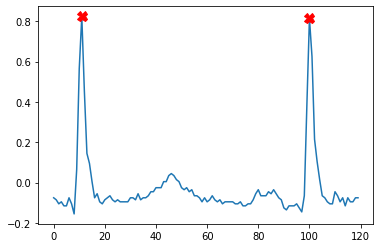

In [ ]:
#@title Plot example Peaks of the non-processed ecg
subject_idx = 1

pk_loc = int(peaks[subject_idx][333][0]) + 1
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1
print(pk_loc, pk_loc_previous)

plt.plot( ecgs[subject_idx][(pk_loc-100):(pk_loc + 20), 0])

plt.plot([100], [ecgs[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([100 - (pk_loc - pk_loc_previous)],
         ecgs[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)


print(headers[subject_idx][101][0])


##***2*** Input Building

###***2.1*** Preprocessing of the ecg data

Filter ecg signal of every subject, normalisation with mean and std and Resampling to lower freq



In [ ]:
#@title Define useful preprocessing functions
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

def normalisation_function (ecg):
  X = ecg
  # Normalisation - Z-score
  rec_mean = np.nanmean(X)
  rec_std = np.nanstd(X)
  X = (X - rec_mean)/rec_std
  return X

def signal_preprocessing(data, fs): 
  # BP Filtering
  filtered_ecg = bandpass_filter(data, 1, 35, fs, 3)
  # Normalisation - Z-score
  X = normalisation_function(filtered_ecg)
  return X

In [ ]:
#@title Filtering/Normalising/Resampling
# Filter ecg signal of every subject, normalisation with mean and std and Resampling to lower freq
ecgs_filt = list()
peaks_rs = list()
fs_final = min(fs_list)

# Pre processing the the full ecg signal from each patient
for i in range(len(ecgs)):
  filt_ecg1 = np.empty((len(ecgs[i][:,0]),1))
  filt_ecg1[:,0] = signal_preprocessing(ecgs[i][:,0], fs_list[i])
  filt_ecg2 = np.empty((len(ecgs[i][:,1]),1))
  filt_ecg2[:,0] = signal_preprocessing(ecgs[i][:,1], fs_list[i])

  # Resampling to lower freq for complexity reasons
  n_samples = len(filt_ecg2)
  fs = fs_list[i]
  duration = n_samples / fs
  filt_ecg1_rs = resample(filt_ecg1, int(duration * fs_final))
  filt_ecg2_rs = resample(filt_ecg2, int(duration * fs_final))
  filt_res_ecg = np.concatenate((filt_ecg1_rs, filt_ecg2_rs), axis=1)
  ecgs_filt.append(filt_res_ecg)

  # Updating the sample number of the new peaks rounding to closest sample
  rs_peak_subj = np.empty((len(peaks[i]),1))
  rs_peak_subj = np.ceil(peaks[i] * fs_final / fs)
  peaks_rs.append(rs_peak_subj.astype(int))


In [ ]:
print(headers[0].shape)
print('ecg dimensions = ', len(ecgs_filt), ecgs_filt[0].shape[0], ecgs_filt[0].shape[1])
print('rpeaks dimensions = ', len(peaks_rs), peaks_rs[0].shape)
print('headers/labels dimensions = ', len(headers), headers[0].shape)

(2851,)
ecg dimensions =  105 230400 2
rpeaks dimensions =  105 (2851, 1)
headers/labels dimensions =  105 (2851,)


32872 32783
32872 32783


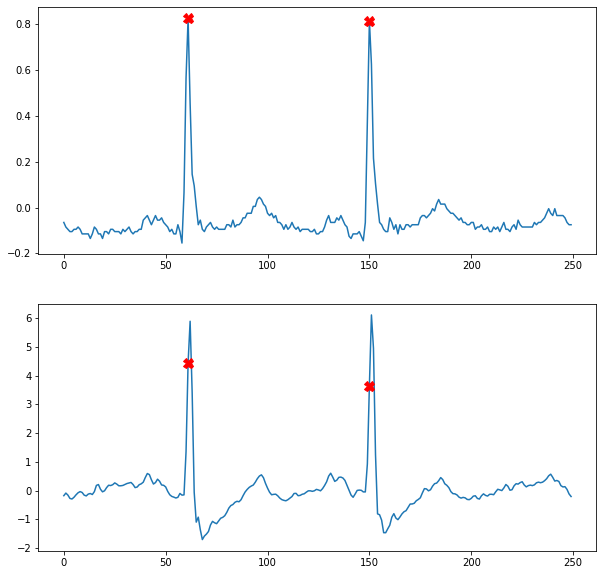

In [ ]:
#@title Plotting pre processed vs non-pre processed ecg

subject_idx = 1

pk_loc = int(peaks_rs[subject_idx][333][0]) + 1
pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1
print(pk_loc, pk_loc_previous)

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-150):(pk_loc + 100), 0])
plt.plot([150], [ecgs_filt[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([150 - (pk_loc - pk_loc_previous)],
         ecgs_filt[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-150):(pk_loc + 100), 0])
plt.plot([150], [ecgs[subject_idx][pk_loc,0]],
         marker='X',
         color='red',
         ms=10)
plt.plot([150 - (pk_loc - pk_loc_previous)],
         ecgs[subject_idx][pk_loc_previous,0],
         marker='X', color='red',
         ms=10)

32876 32787
32872 32783
32872 32783


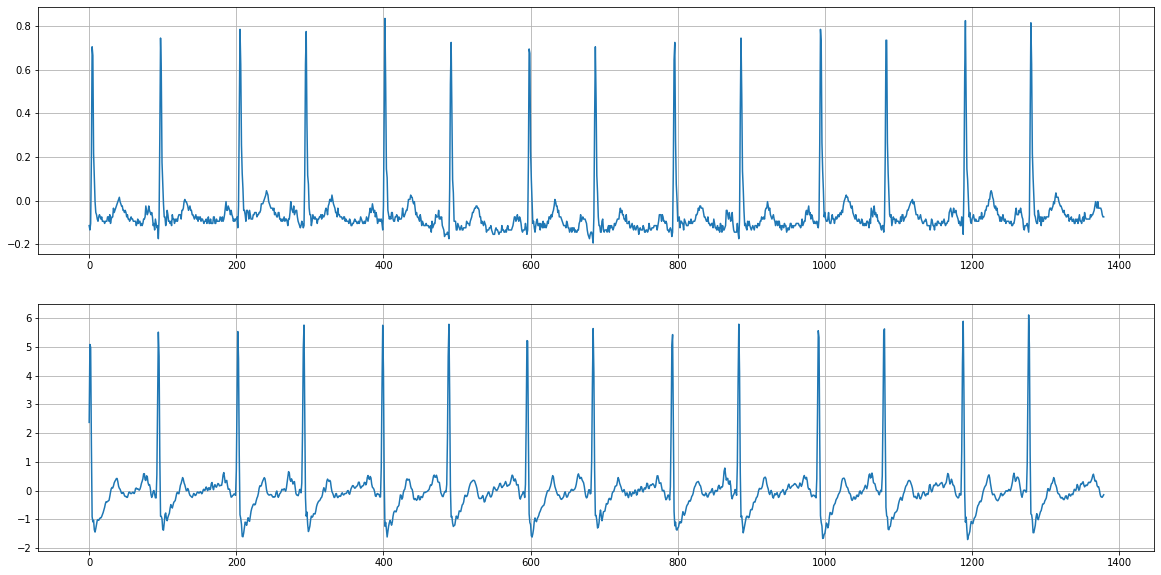

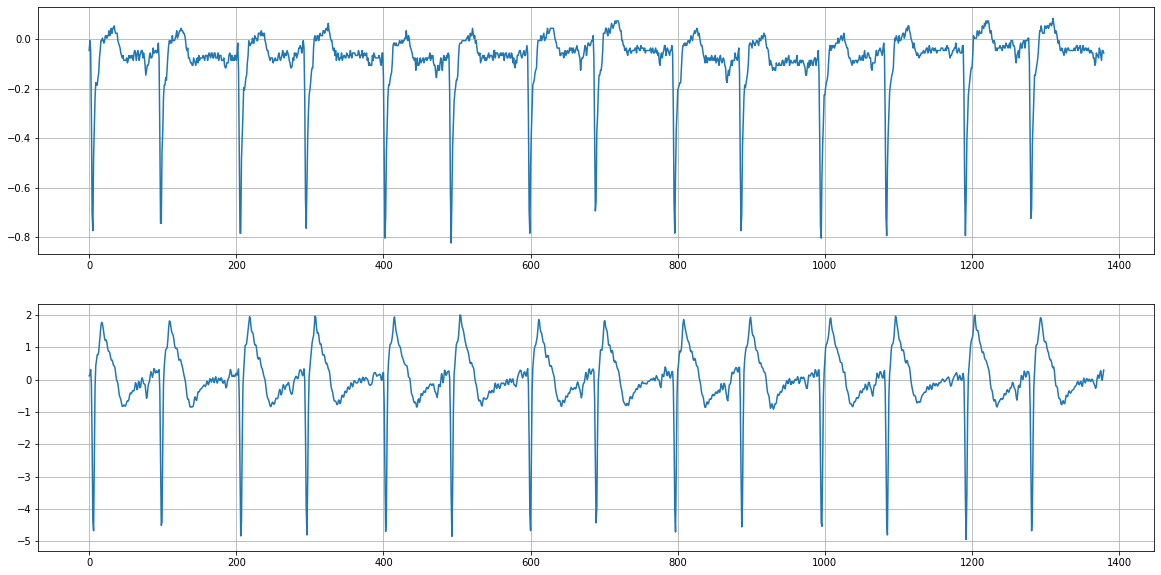

In [ ]:
#@title Plotting longer of pre processed vs non-pre processed ecg

subject_idx = 1

length_time = 10

pk_loc = int(peaks_rs[subject_idx][333][0]) + 1 + 4
pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1 + 4
print(pk_loc, pk_loc_previous)

plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 0])
plt.grid(0.3)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 0])
plt.grid(0.3)
plt.savefig(figures_directory + '/lead0_pp_npp.png')


plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
plt.plot( ecgs_filt[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 1])
plt.grid(0.3)

pk_loc = int(peaks[subject_idx][333][0]) + 1 #+ 4
pk_loc_previous = int(peaks[subject_idx][332][0]) + 1 #+ 4
print(pk_loc, pk_loc_previous)

plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-length_time*128):(pk_loc + 100), 1])
plt.grid(0.3)
plt.savefig(figures_directory + '/lead1_pp_npp.png')



###***2.2*** Building inputs sequences based on the R peaks position, per subject and padding to a predefined fixed length


In [ ]:
#@title Input Sequences parameters
sample_predefined_len = 225
left_factor = 1
right_factor = 0.6

In [ ]:
# List with samples correlated by index
input_ecg_windows = list()
input_labels = list()
samples_origin = list()

median_hb_subj = list()
rr_int_per_subj = list()

# Get median RR per patient
for i in range(len(ecgs_filt)):
  rpeaks = peaks_rs[i]
  # Vec with all the RR interval duration (in n_samples) for the current subject
  hb_freq_vec = np.subtract(rpeaks[1:], rpeaks[:-1])
  # Int value of the median RR interval duration (in n_samples) for the current subject
  median_hb_durantion = np.median(hb_freq_vec)
  # Store vec and median val
  median_hb_subj.append(median_hb_durantion)
  rr_int_per_subj.append(hb_freq_vec)

# Determining median RR across patients
median_median_hb_duration = np.median(median_hb_subj)

# Defining heart beat window for model input
# Using 1.2 times the median RR interval (across patients) according to https://www.hindawi.com/journals/jhe/2021/7167891/
input_window_length_left = int(median_median_hb_duration * left_factor)
input_window_length_right = int(round(median_median_hb_duration * right_factor))

# Across subjects
for i in range(len(ecgs_filt)):
  current_labels = headers[i]
  rpeaks = peaks_rs[i]
  current_ecgs = ecgs_filt[i]
  fs = fs_list[i]

  input_window_length_left = int(median_hb_subj[i] * left_factor)
  input_window_length_right = int(round(median_hb_subj[i] * right_factor))
  no_samples = input_window_length_left + input_window_length_right

  if no_samples < sample_predefined_len:
    n_padding = sample_predefined_len - no_samples
  else:
    print('pre defined num of samples is less than current no_samples')
    print(no_samples, sample_predefined_len)
    break

  for rpeak_index in range(len(rpeaks)):
    current_peak = rpeaks[rpeak_index][0]
    sample_i = current_peak - input_window_length_left
    sample_f = current_peak + input_window_length_right
    # Discard peaks on the edges of the ecg recordings
    if sample_i > 0 and sample_f < len(current_ecgs):
      input_widnow1 = np.empty((no_samples,1))
      input_widnow1[:,0] = current_ecgs[sample_i:sample_f,0]
      input_widnow2 = np.empty((no_samples,1))
      input_widnow2[:,0] = current_ecgs[sample_i:sample_f,1]
      # Adding padding
      padding_vec = np.zeros((n_padding,1))
      padded_input_widnow1 = np.concatenate((input_widnow1, padding_vec), axis=0)
      padded_input_widnow2 = np.concatenate((input_widnow2, padding_vec), axis=0)
      # Creating sample
      input_widnows = np.concatenate((padded_input_widnow1, padded_input_widnow2), axis=1)
      input_ecg_windows.append(input_widnows)
      # Get this peak's label
      current_label = current_labels[rpeak_index]
      input_labels.append(current_label)
      # Get this samples's subject index
      samples_origin.append(i)
      # if n_padding < 10 and i == 39 and current_label == 'S': 
      #   print(len(input_ecg_windows)-1)
      #   print(current_label)
      #   print(i)

n_samples = len(input_ecg_windows)
# Convert to array
input_ecg_windows = np.asarray(input_ecg_windows)
print('Total set dimension = ', n_samples)
print('Sample shape = ', input_ecg_windows.shape)


Total set dimension =  244181
Sample shape =  (244181, 225, 2)


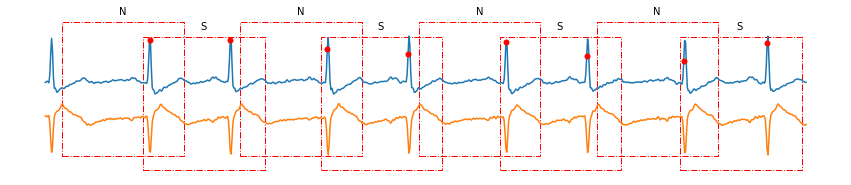

In [ ]:
# Plotting segmentation scheme
subject_idx = 1
center_peak_idx = 333
displacemnet = 400

pk_loc = int(peaks_rs[subject_idx][center_peak_idx][0]) + 1
# pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1

plt.figure(figsize= (15,3))
plt.plot( ecgs_filt[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 0])

counter = 0
for peak in [-3,-2,-1,0,1,2,3,4]:
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1 
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs_filt[subject_idx][pk_loc_other,0]],
          marker='.',
          color='red',
          ms=10)

  top_left_corner_x = displacemnet - offset - int(median_hb_subj[subject_idx] * 1)
  top_left_corner_y = -11 + (-1)**counter
  top_len = int(median_hb_subj[subject_idx] * 1) + int(median_hb_subj[subject_idx] * 0.4)
  side_len = 18 

  plt.text(displacemnet - offset - top_len/4, top_left_corner_y + side_len + 1,
           headers[subject_idx][center_peak_idx + peak])
  
  plt.gca().add_patch(Rectangle((top_left_corner_x,top_left_corner_y),
                                top_len,
                                side_len,
                                edgecolor='red',
                                facecolor='none',
                                ls = '-.',
                                lw=1))
  
  counter += 1

plt.plot( -5 + ecgs_filt[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 1])
plt.axis('off')

plt.savefig(figures_directory + '/segmentation_scheme.png')


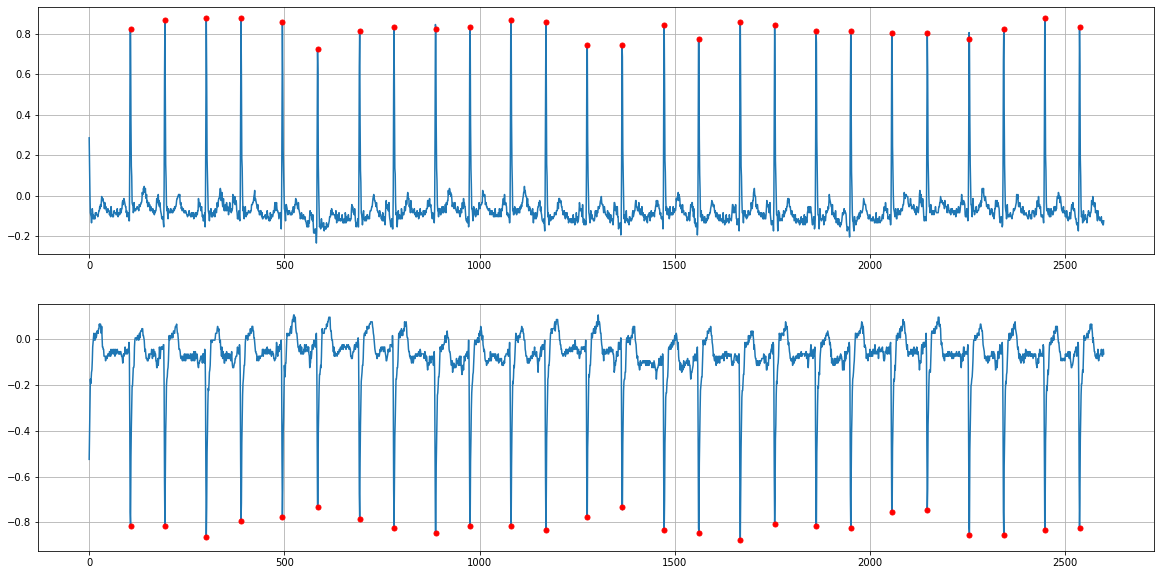

In [ ]:
#@title Plotting long signal - 2 leads
subject_idx = 1
center_peak_idx = 33
displacemnet = 128 * 10

pk_loc = int(peaks_rs[subject_idx][center_peak_idx][0]) + 1 + 4
# pk_loc_previous = int(peaks_rs[subject_idx][332][0]) + 1 + 4

plt.figure(figsize= (20,10))
plt.subplot(2,1,1)
plt.plot( ecgs[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 0])

counter = 0
for peak in np.arange(start=-12, step=1, stop=14):
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs[subject_idx][pk_loc_other,0]],
          marker='.',
          color='red',
          ms=10)
  plt.grid(0.3)

  
  counter += 1


plt.subplot(2,1,2)
plt.plot(ecgs[subject_idx][(pk_loc-displacemnet):(pk_loc + displacemnet+40), 1])
for peak in np.arange(start=-12, step=1, stop=14):
  pk_loc_other = int(peaks_rs[subject_idx][center_peak_idx + peak][0]) + 1
  offset = (pk_loc - pk_loc_other)
  plt.plot([displacemnet - offset], [ecgs[subject_idx][pk_loc_other,1]],
          marker='.',
          color='red',
          ms=10)
  plt.grid(0.3)

plt.savefig(figures_directory + '/leads_npp_ann.png')



Median of median RR interval duration across subjects =  100.0


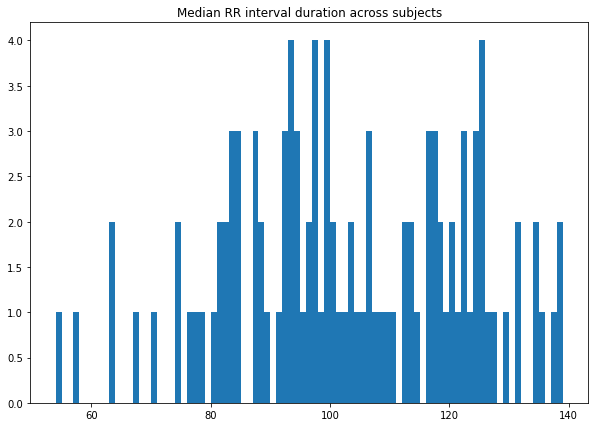

In [ ]:
#@title Histogram of median RR interval duration across subjects

rr_intvector = median_hb_subj
fig = plt.figure(figsize =(10, 7))
binwidth = 1
plt.hist(rr_intvector, bins=range(int(min(rr_intvector)), int(max(rr_intvector) + binwidth), binwidth))
plt.title('Median RR interval duration across subjects')
print('Median of median RR interval duration across subjects = ', np.median(rr_intvector))

In [ ]:
#Normal sinus rhythm (0), Premature ventricular complex(1), Premature atrial complex(2)
classes_name = ['N', 'V', 'S']

In [ ]:
#@title Labels Encoding
num_classes = len(classes_name)
one_hot_labels = np.zeros((n_samples,num_classes), dtype=bool)
for i in range(n_samples):
  for j, x in enumerate(classes_name):
    single_label = input_labels[i]
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labxels = one_hot_labels * 1   

print(one_hot_labxels[71], one_hot_labxels[16], one_hot_labxels[69])

[0 0 1] [0 1 0] [1 0 0]


#### Plot one example sample of each class


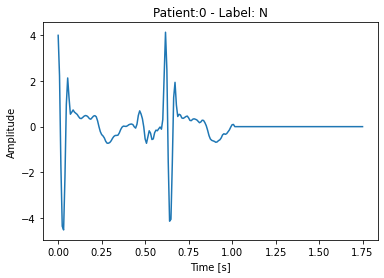

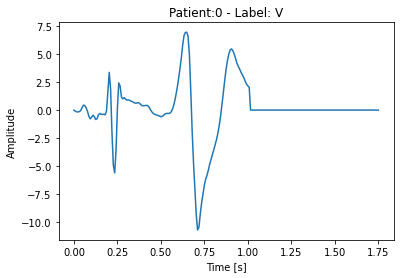

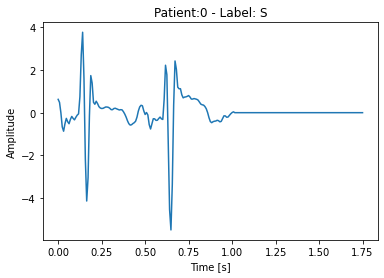

In [ ]:
# Plot one example sample of ech class

sample_pac = 71
sample_pvc = 16
sample_n = 69

lead = 1

input_sample_len = len(input_ecg_windows[1])

t = np.arange(0, input_sample_len/fs_final, 1/fs_final) 
fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_n]) + " - Label: " + classes_name[0])
axs.plot(t, input_ecg_windows[sample_n][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' +  classes_name[0] + '_example_' + str(lead))
plt.show()


fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_pvc]) + " - Label: " + classes_name[1])
axs.plot(t, input_ecg_windows[sample_pvc][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' + classes_name[1] + '_example_' + str(lead))
plt.show()


fig, axs = plt.subplots()
axs.set_title("Patient:" + str(samples_origin[sample_pvc]) + " - Label: " + classes_name[2])
axs.plot(t, input_ecg_windows[sample_pac][:,lead], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.savefig(figures_directory + '/' + classes_name[2] + '_example_' + str(lead))
plt.show()


#### Check dataset distribution

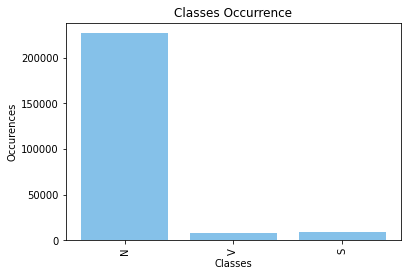

[226782   7794   9605]


In [ ]:
plt.bar(x=classes_name,height=one_hot_labels.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

print(one_hot_labels.sum(axis=0))

##***3*** Model

###***3.1*** Split


In [ ]:
from sklearn.model_selection import train_test_split
# 0.8  0.1 0.1
X_train, X_val, y_train, y_val = train_test_split(input_ecg_windows, one_hot_labxels, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=one_hot_labxels)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=SEED,
                               shuffle=True, stratify=y_val)

In [ ]:
#@title Input and output structure shape

print('X_train shape = ', X_train.shape, '  y_train shape = ', y_train.shape)
print('X_val shape = ', X_val.shape, '     y_val shape = ', y_val.shape)
print('X_test shape = ', X_test.shape, '    y_test shape = ', y_test.shape)

X_train shape =  (195363, 200, 2)   y_train shape =  (195363, 3)
X_val shape =  (24421, 200, 2)      y_val shape =  (24421, 3)
X_test shape =  (24420, 200, 2)     y_test shape =  (24420, 3)


Inspect split folds distribution - Ensure stratification

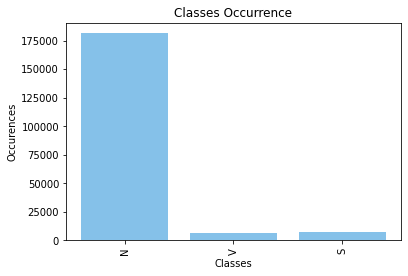

[181444   6235   7684]


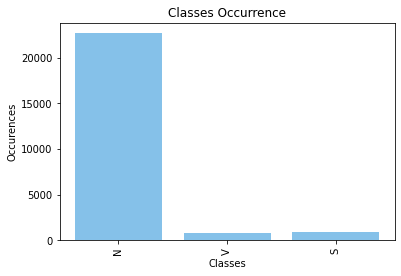

[22681   779   961]


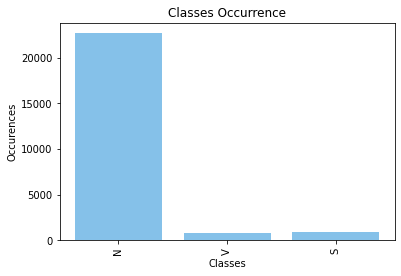

[22680   780   960]


In [ ]:
plt.bar(x=classes_name,height=y_train.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()
print(y_train.sum(axis=0))
plt.bar(x=classes_name,height=y_val.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()
print(y_val.sum(axis=0))

plt.bar(x=classes_name,height=y_test.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()
print(y_test.sum(axis=0))


### 3.2 Compute Class Weights

"treat every instance of class 1 as 50 instances of class 0" means that in your loss function you assign higher value to these instances. Hence, the loss becomes a weighted average, where the weight of each sample is specified by class_weight and its corresponding class.

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(np.argmax(y_train,axis=1)),
                                                  y=np.argmax(y_train,axis=1))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.35890412468860916, 1: 10.444426623897353, 2: 8.474882873503384}

### Data augmentationa by oversampling with SMOTE

https://www.jair.org/index.php/jair/article/view/10302/24590

Synthetic samplesare generated in the following way: Take the difference between the feature vector (sample)under consideration and its nearest neighbor. Multiply this difference by a random numberbetween 0 and 1, and add it to the feature vector under consideration.  This causes theselection of a random point along the line segment between two specific features.  Thisapproach effectively forces the decision region of the minority class to become more general.

Showed good results with ECG data in:
https://www.sciencedirect.com/science/article/pii/S0167739X20305410

In [ ]:
DICT_os = {0: y_train.sum(axis=0)[0], 1:int(y_train.sum(axis=0)[1] * class_weights[1]), 2:int(y_train.sum(axis=0)[2] * class_weights[2])}
factor_us = 0.5
DICT_us = {0: int(y_train.sum(axis=0)[0] * class_weights[0]), 1:int(y_train.sum(axis=0)[1] * class_weights[1]), 2:int(y_train.sum(axis=0)[2] * class_weights[2])}

DICT_os, DICT_us, DICT_us[0] / DICT_us[1]

({0: 181444, 1: 65121, 2: 65121}, {0: 65121, 1: 65121, 2: 65121}, 1.0)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sm = SMOTE(sampling_strategy = DICT_os,
           random_state=SEED)
X_train_os0, y_train_os0 = sm.fit_resample(X_train[:,:,0], y_train)
X_train_os1, y_train_os1 = sm.fit_resample(X_train[:,:,1], y_train)

rus = RandomUnderSampler(sampling_strategy = DICT_us,
                         random_state=SEED)
X_train_res0, y_train_res0 = rus.fit_resample(X_train_os0, y_train_os0)
X_train_res1, y_train_res1 = rus.fit_resample(X_train_os1, y_train_os1)

print('X_train_ch1 shape = ', X_train_res0.shape, '  y_train_ch1 shape = ', y_train_res0.shape)
print('X_train_ch2 shape = ', X_train_res1.shape, '  y_train_ch2 shape = ', y_train_res1.shape)

# Join channels
X_train_res = np.stack((X_train_res0, X_train_res1), axis=-1)
y_train_res = y_train_res1
print('X_train shape = ', X_train_res.shape, '  y_train shape = ', y_train_res.shape)

del X_train_res0, X_train_res1, y_train_res0, y_train_res1, X_train_os0, X_train_os1, y_train_os0, y_train_os1

X_train_ch1 shape =  (195363, 200)   y_train_ch1 shape =  (195363, 3)
X_train_ch2 shape =  (195363, 200)   y_train_ch2 shape =  (195363, 3)
X_train shape =  (195363, 200, 2)   y_train shape =  (195363, 3)


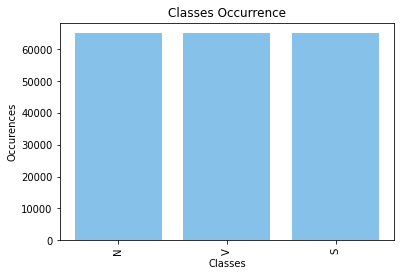

How much of each class we changed wrt initial counts:  [ 0.35890412 10.44442662  8.47488287]


In [ ]:
  plt.bar(x=classes_name,height=y_train_res.sum(axis=0), facecolor ='#85c1e9')
  plt.title("Classes Occurrence", color = "black")
  plt.tick_params(axis="both", colors = "black")
  plt.xlabel("Classes", color = "black")
  plt.ylabel("Occurences", color = "black")
  plt.xticks(rotation=90)
  plt.yticks
  plt.show()

print('How much of each class we changed wrt initial counts: ', np.divide(y_train_res.sum(axis=0), y_train.sum(axis=0)))

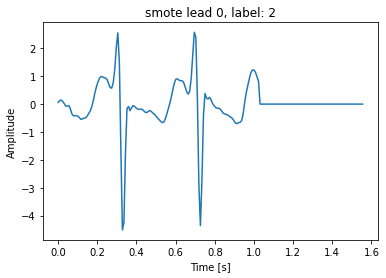

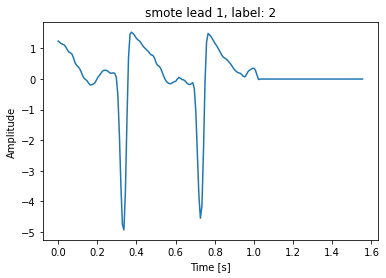

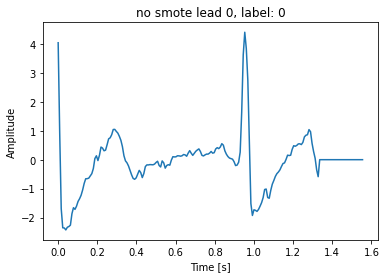

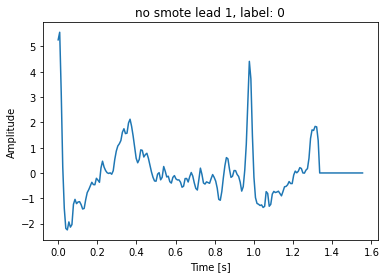

In [ ]:
sampel = 135000

fig, axs = plt.subplots()
axs.set_title('smote lead 0, label: ' + str(np.argmax(y_train_res[sampel])))
axs.plot(t, X_train_res[sampel,:,0], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()

fig, axs = plt.subplots()
axs.set_title('smote lead 1, label: ' + str(np.argmax(y_train_res[sampel])))
axs.plot(t, X_train_res[sampel,:,1], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()

fig, axs = plt.subplots()
axs.set_title('no smote lead 0, label: ' + str(np.argmax(y_train[sampel])))
axs.plot(t,  X_train[sampel,:,0], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()

fig, axs = plt.subplots()
axs.set_title('no smote lead 1, label: ' + str(np.argmax(y_train[sampel])))
axs.plot(t, X_train[sampel,:,1], color='C0')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()


In [ ]:
print('SMOTE? Choose from Y/N: ')
valid = False
while valid == False:
  smote = input()
  if smote != 'Y' and smote != 'N':
    print('Invalid selection. Choose from available options.')
  else:
    valid = True 
    print('Split chosen was: ', smote)

if smote == 'Y':
  X_train_final = X_train_res
  y_train_final = y_train_res
  print('SMOTE TRAINING DATA')

else:
  X_train_final = X_train
  y_train_final = y_train
  print('ORIGINAL TRAINING DATA')

print('X_train_final shape = ', X_train_final.shape, '  y_train_final shape = ', y_train_final.shape)


SMOTE? Choose from Y/N: 
N
Split chosen was:  N
ORIGINAL TRAINING DATA
X_train_final shape =  (195363, 200, 2)   y_train_final shape =  (195363, 3)


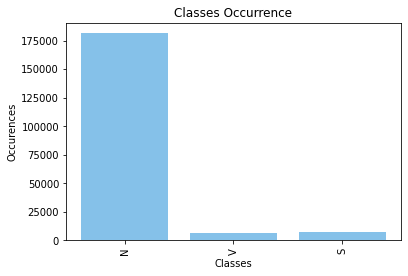

In [ ]:
plt.bar(x=classes_name,height=y_train_final.sum(axis=0), facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

### 3.3 Define Metrics

In [ ]:
# Code source
# https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras/59967457#59967457

# https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#7c80
# In general, if you are working with an imbalanced dataset where all classes are equally important,
# using the macro average would be a good choice as it treats all classes equally.

def f1_score_macro(true, pred): #shapes (batch, 3)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 3)

    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (3,)

    macro_f1 = K.mean(f1)
    
    return macro_f1 #for metrics, return only 'weighted_f1'

def f1_score_N(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)

  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (3,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[0]

def f1_score_V(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)

  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (4,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[1]

def f1_score_S(true, pred): # (N_batch x (3x1))
  #for metrics include these two lines, for loss, don't include them
  #these are meant to round 'pred' to exactly zeros and ones
  predLabels = K.argmax(pred, axis=-1)
  pred = K.one_hot(predLabels, 3)
  
  ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
  pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
  true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

  precision = true_positives / pred_positives 
  recall = true_positives / ground_positives
      #both = 1 if ground_positives == 0 or pred_positives == 0
      #shape (4,)

  f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
      #still with shape (3,)
  return f1[2]

In [ ]:
# metric = tfa.metrics.F1Score(num_classes=3)
# metric.update_state(tf.convert_to_tensor(y_test), tf.convert_to_tensor(pred))
# result = metric.result()
# result[0]

In [ ]:
# y_test, pred

In [ ]:
# pred = K.one_hot(K.argmax(pred, axis=-1), 3) 
# pred

### 3.3 Define Callbacks

In [ ]:
class saveLatesModel(keras.callbacks.Callback):
    def __init__(self, modelSaveLocation):
        super(keras.callbacks.Callback, self).__init__()
        self.modelSaveLocation = modelSaveLocation

    def on_epoch_end(self, epoch, logs={}):
        self.model.save(self.modelSaveLocation, overwrite=True)

# Function to create folders and callbacks for training
def create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric, mode_metric):
      
  callbacks = []

  # Early Stopping - best weights are restored at the end o fteh training
  es_callback = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric, mode = mode_metric,  patience=patience_es, restore_best_weights=True)
  callbacks.append(es_callback)

  # Save last epoch model for overfitting visaulisation purposes
  slem_callback = saveLatesModel(modelSaveLocation= model_dir  + '/lastepoch_model')
  callbacks.append(slem_callback)

  # Reduce learning rate on plateau
  rop_callback = tfk.callbacks.ReduceLROnPlateau(monitor=monitoring_metric, mode = mode_metric, patience=patience_rop, factor=0.5, min_lr=1e-5)
  callbacks.append(rop_callback)

  return callbacks

###***3.4*** Vgg

Run followiung cells all together

In [ ]:
batchsize = 64
patience_es = 15
patience_rop = 8
epochs = 100
learning_rate = 0.001

model_name = 'model_vgg_ncw_bs' + str(batchsize) + '_smote' + smote + '_bpfilt35'
print(model_name)


model_vgg_ncw_bs64_smoteY_bpfilt35


In [ ]:
def build_VGG16(input_shape, learning_rate):
  # Build model
  model = Sequential()

  model.add(Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64,kernel_size=3,padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add (Dense(512, activation='relu'))
  model.add (Dropout(0.4))
  model.add (Dense(3,activation='softmax'))

  return model

In [ ]:

model = build_VGG16(input_shape = X_train.shape[1:], learning_rate=learning_rate)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 200, 64)           448       
                                                                 
 conv1d_37 (Conv1D)          (None, 200, 64)           12352     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 100, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_38 (Conv1D)          (None, 100, 128)          24704     
                                                                 
 conv1d_39 (Conv1D)          (None, 100, 128)          49280     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 50, 128)          0         
 g1D)                                                 

In [ ]:
# ========= Defining saving directory - model_saving_dir =========
now = datetime.now().strftime('%b%d_%H-%M-%S')

model_dir = os.path.join(exp_directory, model_name + '_' + str(now))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print('Directory created named:   ' + model_dir)

# ========= Compile model =========
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss = 'categorical_crossentropy',
    metrics = [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]
)

# ========= Create folders and callbacks and fit =========
monitoring_metric = 'val_f1_score_macro'
mode = 'max'
callbacks = create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric =monitoring_metric, mode_metric = mode)

history = model.fit(
    x = X_train_final,
    y = y_train_final, 
    validation_data=(X_val, y_val),
    batch_size = batchsize,
    epochs = epochs,
    callbacks = callbacks
    # class_weight = class_weights
).history

# Save best epoch model
model.save(model_dir + '/model')

# Save history
with open(model_dir + '/history', 'wb') as file:
    pickle.dump(history, file)

print('History and Model saved at : ', model_dir)
print('Last epoch model saved at : ' + model_dir  + '/lastepoch_model')

Directory created named:   /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37
Epoch 1/100
3053/3053 [==============================] - 82s 26ms/step - loss: 0.2026 - categorical_accuracy: 0.9268 - f1_score_macro: 0.9228 - f1_score_N: 0.9237 - f1_score_V: 0.9415 - f1_score_S: 0.9031 - val_loss: 0.0982 - val_categorical_accuracy: 0.9652 - val_f1_score_macro: 0.8436 - val_f1_score_N: 0.9818 - val_f1_score_V: 0.8862 - val_f1_score_S: 0.6628 - lr: 0.0010
Epoch 2/100
3053/3053 [==============================] - 77s 25ms/step - loss: 0.1068 - categorical_accuracy: 0.9647 - f1_score_macro: 0.9639 - f1_score_N: 0.9661 - f1_score_V: 0.9744 - f1_score_S: 0.9512 - val_loss: 0.1055 - val_categorical_accuracy: 0.9670 - val_f1_score_macro: 0.8449 - val_f1_score_N: 0.9827 - val_f1_score_V: 0.8692 - val_f1_score_S: 0.6827 - lr: 0.0010
Epoch 3/100
3053/3053 [==============================] - 80s 26ms/step - loss: 0.0931 - catego

#### Plotting Training


best epoch =  40
Train and Val results saved at :  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37


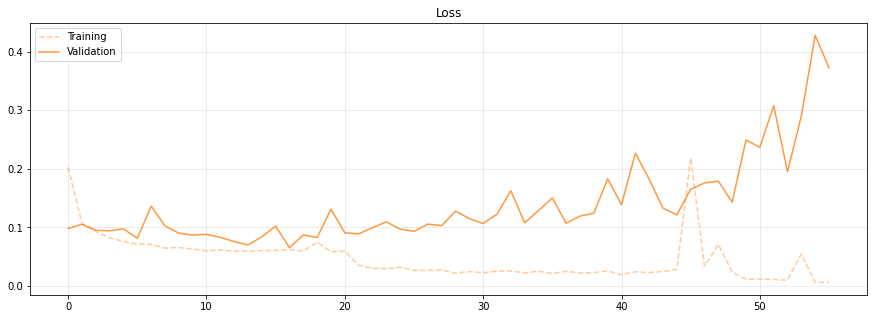

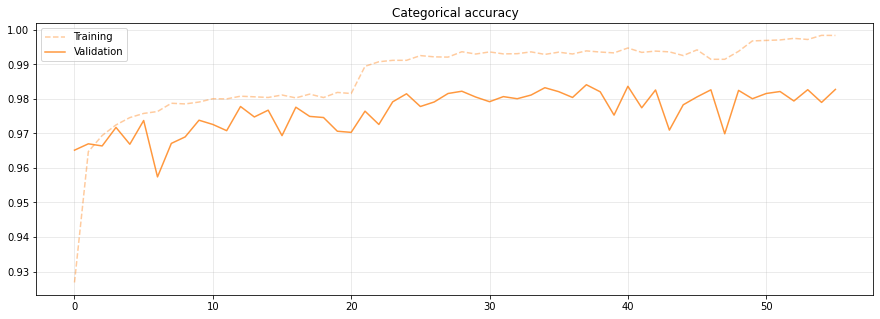

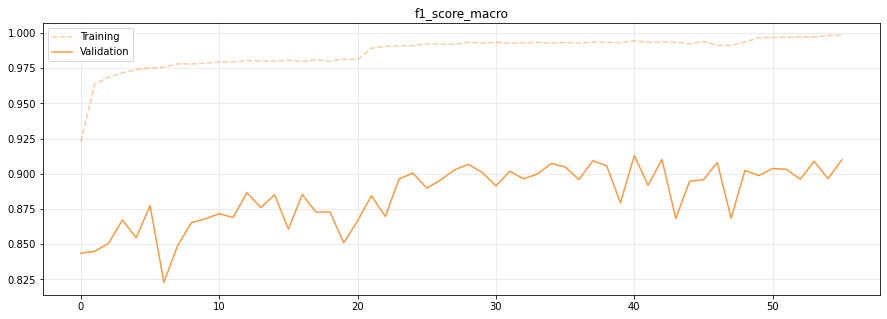

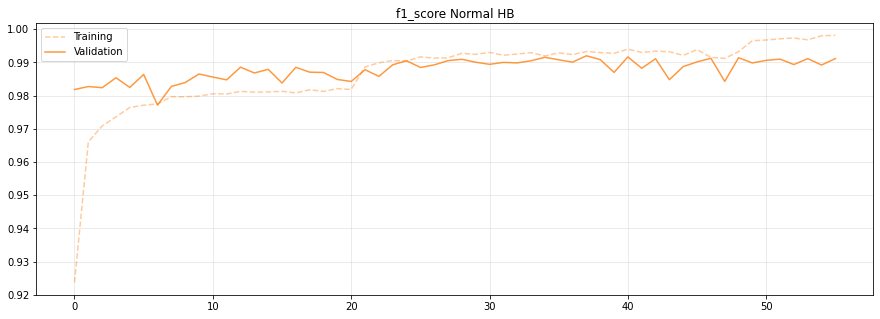

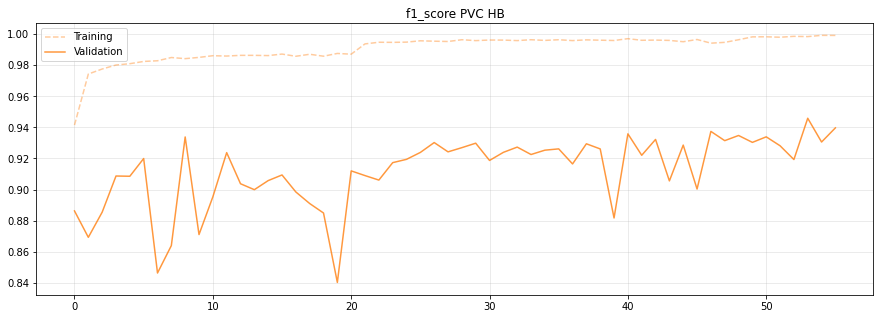

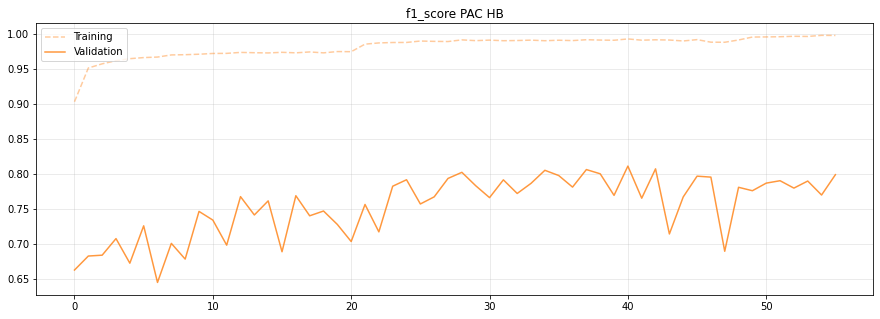

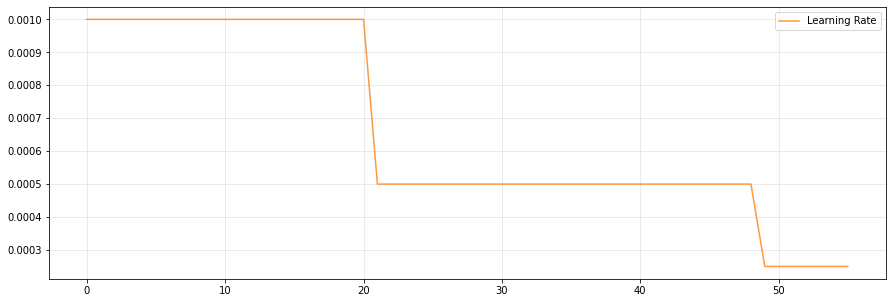

In [ ]:
#plot performances
with open(model_dir + '/history', 'rb') as file:
  history = pickle.load(file)

# Plot and save the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/loss.png')

plt.figure(figsize=(15,5))
plt.plot(history['categorical_accuracy'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical accuracy')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/categorical_accuracy.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_macro'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_macro'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score_macro')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_macro.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_N'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_N'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score Normal HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_N.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_V'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_V'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PVC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_V.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_S'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_S'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PAC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_S.png')

plt.figure(figsize=(15,5))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.legend()
plt.grid(alpha=.3)
plt.savefig(model_dir + '/lr.png')

# Create val and train rows for results df - FOR LAST EPOCH MODEL
results_train_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][-1]))},
                                          index=[0])
results_val_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][-1]))},
                                          index=[0])

results_train_row_tr_vl_ts.to_csv(model_dir + '/results_train_row_tr_vl_ts.csv', index=False)
results_val_row_tr_vl_ts.to_csv(model_dir + '/results_val_row_tr_vl_ts.csv', index=False)

# Create val and train rows for results df - FOR BEST MODEL
if mode == 'max':
  best_epoch = np.where(history[monitoring_metric] == np.amax(history[monitoring_metric]))[0][0]
elif mode == 'min':
  best_epoch = np.where(history[monitoring_metric] == np.amin(history[monitoring_metric]))[0][0]
print('best epoch = ', best_epoch)
results_train_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][best_epoch]))},
                                          index=[0])
results_val_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][best_epoch]))},
                                          index=[0])

results_train_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv', index=False)
results_val_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv', index=False)

print('Train and Val results saved at : ', model_dir)

In [ ]:
results_train_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.006828,0.998393,0.998155,0.999207,0.9977,0.998354


In [ ]:
results_train_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.019385,0.994758,0.993994,0.997127,0.992729,0.994616


In [ ]:
results_val_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.372398,0.982761,0.99116,0.939701,0.798901,0.90992


In [ ]:
results_val_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.138762,0.983662,0.991656,0.935851,0.811165,0.912891


#### Evaluate Model

764/764 [==============================] - 7s 7ms/step - loss: 0.1321 - categorical_accuracy: 0.9820 - f1_score_macro: 0.9067 - f1_score_N: 0.9907 - f1_score_V: 0.9525 - f1_score_S: 0.7770
Test loss: 0.132102
Test categorical accuracy:  98.198%
Classes                    N        V        S
Accuracy (%):            [98.313 99.685 98.399]
Specificity (%):         [96.264 99.742 98.662]
Precision (%):           [99.71  92.606 73.768]
Sensitivity/Recall (%):  [98.47  97.949 91.979]
F1-score (%):            [0.991 0.952 0.819]
Macro Single F1-score (%):  0.9206666666666666


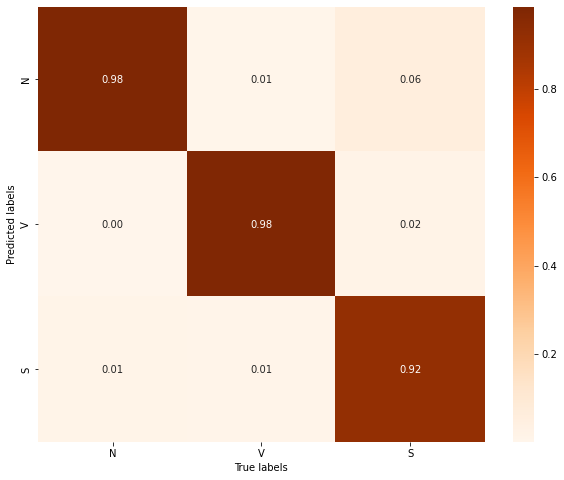

In [ ]:
model = keras.models.load_model(model_dir + '/model', custom_objects={    'f1_score_macro': f1_score_macro,
                                                                          'f1_score_N': f1_score_N,
                                                                          'f1_score_V': f1_score_V,
                                                                          'f1_score_S':f1_score_S} )

score = model.evaluate(X_test, y_test) 
print('Test loss: ' + str(round(score[0],6))) 
print('Test categorical accuracy: ', str(round(score[1]*100,3)) + '%')

# Predict test
pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1) 
true = np.argmax(y_test,axis = 1)

# Plot and save confusion matrix
cm = confusion_matrix(true, pred)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm.T, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Oranges", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig(model_dir + '/test_confusion_matrix.png')

# Commpute and print metrics
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

TPR = TP/(TP+FN + K.epsilon()) # Sensitivity/Recall - Percenatge of correct positive diagnosis over all TRUE positive cases
TPR_oa = np.sum(TP) / (np.sum(TP) + np.sum(FN))
TNR = TN/(TN+FP) # Specificity
TNR_oa = np.sum(TN) / (np.sum(TN) + np.sum(FP))
PPV = TP/(TP+FP + K.epsilon()) # Precision - - Percenatge of correct positive diagnosis over all PREDICTED positive cases
PPV_oa = np.sum(TP) / (np.sum(TP) + np.sum(FP))

print('Classes                    N        V        S')
print('Accuracy (%):           ', np.around(100*(TP+TN)/(TP+TN+FP+FN),3))
print('Specificity (%):        ', np.around(TNR*100,3))
print('Precision (%):          ', np.around(PPV*100,3))
print('Sensitivity/Recall (%): ', np.around(TPR*100,3))

print('F1-score (%):           ', np.around(2 / ((TPR+K.epsilon())**-1 + (PPV+ K.epsilon())**-1), 3))
print('Macro Single F1-score (%): ', np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ))

# To add to resulst DF
results_test_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                        "loss":float("{:.6f}".format(score[0])),
                        "cat_accuracy":float("{:.6f}".format(score[1])),
                        "f1_score_N":float("{:.6f}".format(score[3])), 
                        "f1_score_V":float("{:.6f}".format(score[4])), 
                        "f1_score_S":float("{:.6f}".format(score[5])),
                        "f1_score_macro":float("{:.6f}".format(score[2]))},
                         index=[0])

results_test_row_tr_vl_ts.to_csv(model_dir + '/results_test_row_tr_vl_ts.csv', index=False)

full_test_row = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
full_test_row.loc[0, 'Model Filename'] =  os.path.basename(model_dir)
full_test_row.loc[0, 'Class'] =  ['N', 'V', 'S']
full_test_row.loc[0, 'Accuracy'] =  np.around(100*(TP+TN)/(TP+TN+FP+FN),3).tolist()
full_test_row.loc[0, 'Specificity'] =  np.around(TNR*100,3).tolist()
full_test_row.loc[0, 'Precision'] =  np.around(PPV*100,3).tolist()
full_test_row.loc[0, 'Recall'] = np.around(TPR*100,3).tolist()
full_test_row.loc[0, 'F1-score'] =  np.around(2 / (TPR**-1 + PPV**-1), 3).tolist()
full_test_row.loc[0, 'Macro-F1-score'] =  np.round( np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ), 3)

full_test_row.to_csv(model_dir + '/full_test_row.csv', index=False)

# [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]

# for weighted [np.count_nonzero(true == 0)/len(true), np.count_nonzero(true == 1)/len(true), np.count_nonzero(true == 2)/len(true)]))

In [ ]:
full_test_row

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,"[N, V, S]","[98.313, 99.685, 98.399]","[96.264, 99.742, 98.662]","[99.71, 92.606, 73.768]","[98.47, 97.949, 91.979]","[0.991, 0.952, 0.819]",0.921


In [ ]:
results_test_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37,0.132102,0.981982,0.990694,0.952469,0.777043,0.906735


#### Add results to results DF_train_val_test and DF_full_test

In [ ]:
print('model_saving_dir: ' + model_dir)

new = False
if os.path.exists(rsults_directory + '/results_tr_vl_ts.csv') == False:
  results_tr_vl_ts = pd.DataFrame(columns=['Model Filename',
                                           'subset',
                                          'loss',
                                          'cat_accuracy',
                                          'f1_score_N',
                                          'f1_score_S',
                                          'f1_score_V',
                                          'f1_score_macro'])
  new = True
  results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

# Current model's index on DF's
if new:
  current_index = 0
else:
  current_index = results_tr_vl_ts.index[-1] + 1

# Load previously generated tes, train and val rows
results_test_row_tr_vl_ts  = pd.read_csv(model_dir + '/results_test_row_tr_vl_ts.csv')
results_train_row_tr_vl_ts = pd.read_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv')
results_val_row_tr_vl_ts   = pd.read_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv')

# We could also create easily 3 different DF for the model results on each set

# Fill the jointDF with the data from the columns
for col_str in results_tr_vl_ts.columns:
  if col_str == 'Model Filename':
    results_tr_vl_ts.loc[current_index, col_str] = os.path.basename(model_dir)
  elif col_str == 'subset':
    results_tr_vl_ts.loc[current_index, col_str] = ['train','val','test']
  else:
    train = results_train_row_tr_vl_ts.loc[0, col_str]
    val   = results_val_row_tr_vl_ts.loc[0, col_str]
    test  = results_test_row_tr_vl_ts.loc[0, col_str]

    results_tr_vl_ts.loc[current_index, col_str] = [train, val, test]

# Save updated DF
results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

# Load previously generated full_test_row for current model
full_test_row  = pd.read_csv(model_dir + '/full_test_row.csv')

if os.path.exists(rsults_directory + '/full_test.csv') == False:
  full_test = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
else:
  full_test = pd.read_csv(rsults_directory + '/full_test.csv')

full_test_row = full_test_row.rename(index = {
  0: current_index
})
full_test = pd.concat([full_test, full_test_row], axis=0)

# Save updated DF
full_test.to_csv(rsults_directory + '/full_test.csv', index=False)

model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_vgg_ncw_bs64_smoteY_bpfilt35_Jun07_18-45-37


In [ ]:
full_test

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_Jun01_14-53-57,"['N', 'V', 'S']","[98.071, 99.308, 98.002]","[82.874, 99.475, 99.395]","[98.693, 85.565, 81.217]","[99.237, 94.231, 63.958]","[0.99, 0.897, 0.716]",0.868
1,model_resnet_2epoch_Jun01_17-00-32,"['N', 'V', 'S']","[98.608, 99.627, 98.571]","[87.874, 99.772, 99.467]","[99.073, 93.225, 85.482]","[99.431, 95.256, 76.667]","[0.993, 0.942, 0.808]",0.914
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['N', 'V', 'S']","[98.812, 99.619, 98.792]","[88.851, 99.86, 99.523]","[99.148, 95.618, 87.402]","[99.577, 92.308, 80.938]","[0.994, 0.939, 0.84]",0.924
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
5,model_resnet_bs64_Jun04_14-50-45,"['N', 'V', 'S']","[99.169, 99.767, 99.115]","[93.563, 99.898, 99.565]","[99.507, 96.887, 89.241]","[99.599, 95.769, 88.125]","[0.996, 0.963, 0.887]",0.949
6,model_resnet_cw_bs64_Jun04_16-43-53,"['N', 'V', 'S']","[98.448, 99.726, 98.468]","[96.379, 99.835, 98.687]","[99.719, 95.07, 74.376]","[98.607, 96.41, 93.125]","[0.992, 0.957, 0.827]",0.925
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['N', 'V', 'S']","[98.047, 99.701, 98.092]","[96.897, 99.763, 98.303]","[99.758, 93.162, 69.147]","[98.135, 97.821, 92.917]","[0.989, 0.954, 0.793]",0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['N', 'V', 'S']","[97.514, 99.656, 97.547]","[97.816, 99.738, 97.677]","[99.828, 92.439, 62.44]","[97.491, 97.179, 94.375]","[0.986, 0.947, 0.752]",0.895
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['N', 'V', 'S']","[97.641, 99.627, 97.678]","[97.644, 99.734, 97.813]","[99.815, 92.27, 63.848]","[97.641, 96.41, 94.375]","[0.987, 0.943, 0.762]",0.897


In [ ]:
results_tr_vl_ts

,Model Filename,subset,loss,cat_accuracy,f1_score_N,f1_score_S,f1_score_V,f1_score_macro
0,model_vgg_Jun01_14-53-57,"['train', 'val', 'test']","[0.07002, 0.068835, 0.068096]","[0.976838, 0.976782, 0.976904]","[0.989101, 0.988882, 0.989476]","[0.685058, 0.673492, 0.691116]","[0.870161, 0.875416, 0.885083]","[0.848105, 0.845929, 0.855224]"
1,model_resnet_2epoch_Jun01_17-00-32,"['train', 'val', 'test']","[0.056446, 0.047695, 0.046946]","[0.981952, 0.983457, 0.984029]","[0.991561, 0.992054, 0.9924]","[0.750074, 0.770279, 0.779728]","[0.896693, 0.906843, 0.936126]","[0.879442, 0.889725, 0.90275]"
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['train', 'val', 'test']","[0.048053, 0.045113, 0.043579]","[0.984224, 0.984972, 0.986118]","[0.99253, 0.992821, 0.993525]","[0.786369, 0.787288, 0.810451]","[0.915594, 0.917853, 0.9374]","[0.898162, 0.89932, 0.913791]"
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.012343, 0.082473, 0.035445]","[0.995153, 0.987142, 0.988657]","[0.997623, 0.993635, 0.994702]","[0.931219, 0.813162, 0.841445]","[0.979216, 0.932145, 0.959939]","[0.969352, 0.91298, 0.932028]"
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.032812, 0.03467, 0.035445]","[0.988713, 0.98833, 0.988657]","[0.994646, 0.994398, 0.994702]","[0.839198, 0.835144, 0.841445]","[0.944564, 0.941289, 0.959939]","[0.926136, 0.92361, 0.932028]"
5,model_resnet_bs64_Jun04_14-50-45,"['train', 'val', 'test']","[0.018043, 0.029661, 0.031787]","[0.993115, 0.989845, 0.990254]","[0.996708, 0.995236, 0.995462]","[0.903137, 0.858398, 0.861895]","[0.971582, 0.951401, 0.962117]","[0.957141, 0.935012, 0.939824]"
6,model_resnet_cw_bs64_Jun04_16-43-53,"['train', 'val', 'test']","[0.021232, 0.054751, 0.061469]","[0.990464, 0.985668, 0.983211]","[0.994993, 0.992735, 0.991456]","[0.872368, 0.824751, 0.791478]","[0.977793, 0.955182, 0.954702]","[0.948382, 0.924222, 0.912545]"
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['train', 'val', 'test']","[0.038509, 0.062768, 0.062349]","[0.981194, 0.98014, 0.979197]","[0.98998, 0.989953, 0.989237]","[0.788735, 0.770097, 0.746859]","[0.957377, 0.930297, 0.951051]","[0.912028, 0.896782, 0.895716]"
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['train', 'val', 'test']","[0.055368, 0.066076, 0.073789]","[0.973885, 0.974735, 0.973587]","[0.986069, 0.98698, 0.986254]","[0.732356, 0.727277, 0.705014]","[0.934867, 0.927618, 0.947304]","[0.884429, 0.880625, 0.879524]"
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['train', 'val', 'test']","[0.049204, 0.065158, 0.072744]","[0.977038, 0.976455, 0.974734]","[0.98781, 0.987842, 0.986971]","[0.75938, 0.738188, 0.720136]","[0.933524, 0.922881, 0.940231]","[0.893569, 0.88297, 0.882446]"


In [ ]:
# Computing variance/ measure of overfitting
# new df everytime running all computation again

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

variance_macro_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])
variance_S_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])

test_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
val_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
train_f1_score_macro = np.empty((len(results_tr_vl_ts),1))

test_f1_score_S = np.empty((len(results_tr_vl_ts),1))
val_f1_score_S = np.empty((len(results_tr_vl_ts),1))
train_f1_score_S = np.empty((len(results_tr_vl_ts),1))

for k in range(len(results_tr_vl_ts)):
  test_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])
  
  test_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])

avoidable_bias = 1 - train_f1_score_macro
variance = np.abs(train_f1_score_macro - val_f1_score_macro)
dev_test_variance = np.abs(val_f1_score_macro - test_f1_score_macro)

avoidable_bias_S = 1 - train_f1_score_S
variance_S = np.abs(train_f1_score_S - val_f1_score_S)
dev_test_variance_S = np.abs(val_f1_score_S - test_f1_score_S)

variance_macro_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_macro_df['avoidable_bias'] = avoidable_bias
variance_macro_df['variance'] = variance
variance_macro_df['dev_test_variance'] = dev_test_variance

variance_S_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_S_df['avoidable_bias'] = avoidable_bias_S
variance_S_df['variance'] = variance_S
variance_S_df['dev_test_variance'] = dev_test_variance_S

# Save updated DF
variance_S_df.to_csv(rsults_directory + '/variance_S_df.csv', index=False)
# Save updated DF
variance_macro_df.to_csv(rsults_directory + '/variance_macro_df.csv', index=False)


In [ ]:
variance_S_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524


In [ ]:
variance_macro_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524


###***3.5*** ResNet

Run followiung cells all together

In [ ]:
batchsize = 64
patience_es = 10
patience_rop = 5
epochs = 100
learning_rate = 0.001

model_name = 'model_resnet_ncw_bs' + str(batchsize) + '_smote' + smote + '_bpfilt35'

print(model_name)


model_resnet_ncw_bs64_smoteY_bpfilt35


In [ ]:
# ResNet model definition 
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=2, win_len=5000, classes=3): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Softmax (chnaged from Sigmoid) activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)

    # # Compile Model
    # model.compile(
    #     optimizer = keras.optimizers.Adam(learning_rate),
    #     loss = 'categorical_crossentropy',
    #     metrics = metrics.categorical_accuracy
    # )
    return model

In [ ]:

model = resnet(N=8, ch=X_train.shape[-1], win_len=X_train.shape[-2], classes=y_train.shape[-1])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 200, 2)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 200, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 200, 64)      0           ['batch_normalization[0][0]']

In [ ]:
# ========= Defining saving directory - model_saving_dir =========
now = datetime.now().strftime('%b%d_%H-%M-%S')

model_dir = os.path.join(exp_directory, model_name + '_' + str(now))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print('Directory created named:   ' + model_dir)

# ========= Compile model =========
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss = 'categorical_crossentropy',
    metrics = [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]
)

# ========= Create folders and callbacks and fit =========
monitoring_metric = 'val_f1_score_macro'
mode = 'max'
callbacks = create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric =monitoring_metric, mode_metric = mode)

history = model.fit(
    x = X_train_final,
    y = y_train_final, 
    validation_data=(X_val, y_val),
    batch_size = batchsize,
    epochs = epochs,
    callbacks = callbacks
    # class_weight = class_weights
).history

# Save best epoch model
model.save(model_dir + '/model')

# Save history
with open(model_dir + '/history', 'wb') as file:
    pickle.dump(history, file)

print('History and Model saved at : ', model_dir)
print('Last epoch model saved at : ' + model_dir  + '/lastepoch_model')

Directory created named:   /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07
Epoch 1/100
3053/3053 [==============================] - 174s 51ms/step - loss: 0.1471 - categorical_accuracy: 0.9520 - f1_score_macro: 0.9509 - f1_score_N: 0.9540 - f1_score_V: 0.9639 - f1_score_S: 0.9349 - val_loss: 0.0546 - val_categorical_accuracy: 0.9818 - val_f1_score_macro: 0.8951 - val_f1_score_N: 0.9912 - val_f1_score_V: 0.9098 - val_f1_score_S: 0.7843 - lr: 0.0010
Epoch 2/100
3053/3053 [==============================] - 156s 51ms/step - loss: 0.0878 - categorical_accuracy: 0.9707 - f1_score_macro: 0.9700 - f1_score_N: 0.9726 - f1_score_V: 0.9780 - f1_score_S: 0.9593 - val_loss: 0.0786 - val_categorical_accuracy: 0.9724 - val_f1_score_macro: 0.8663 - val_f1_score_N: 0.9858 - val_f1_score_V: 0.9084 - val_f1_score_S: 0.7047 - lr: 0.0010
Epoch 3/100
3053/3053 [==============================] - 156s 51ms/step - loss: 0.0678 - 

#### Plotting Training


best epoch =  24
Train and Val results saved at :  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07


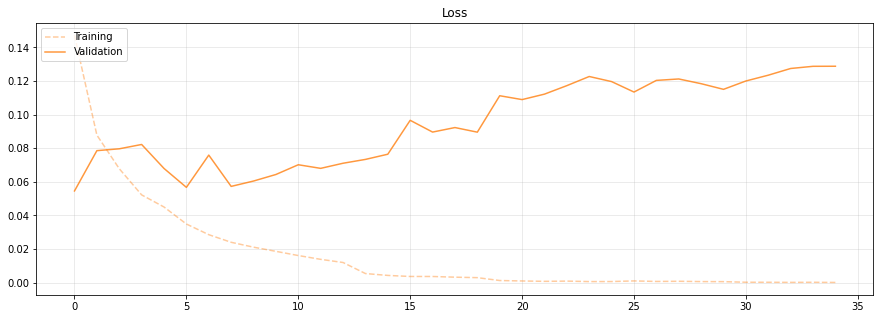

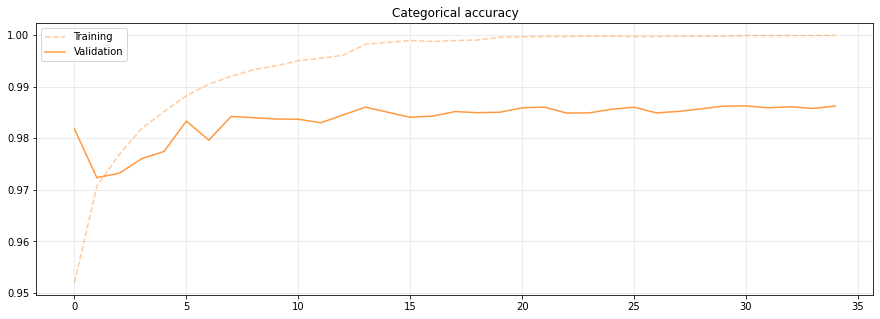

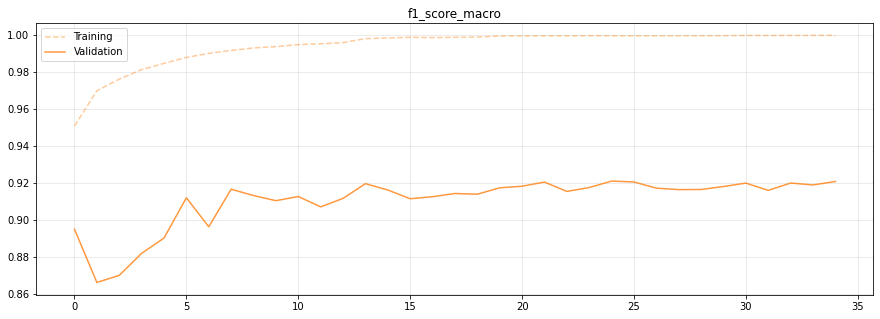

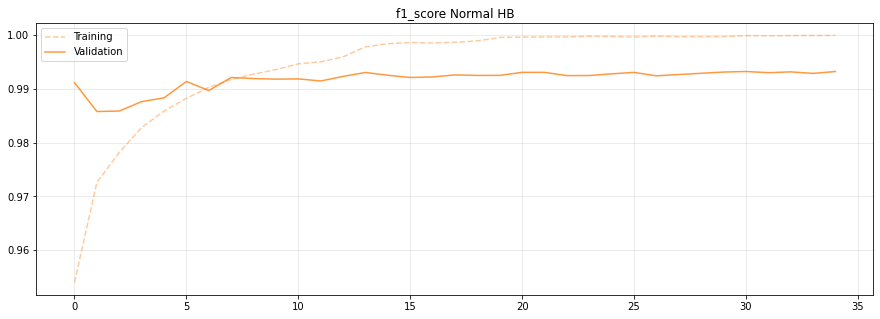

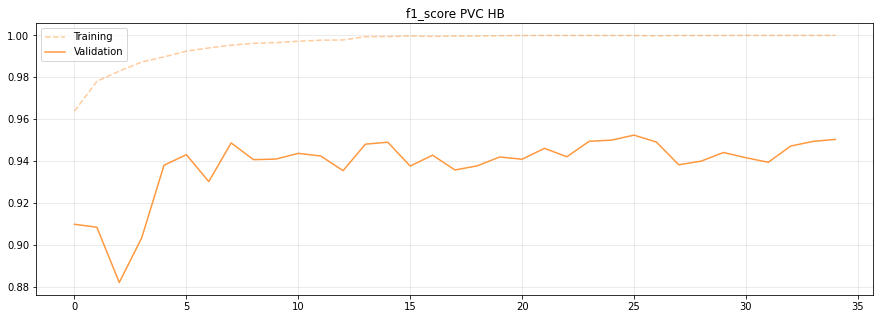

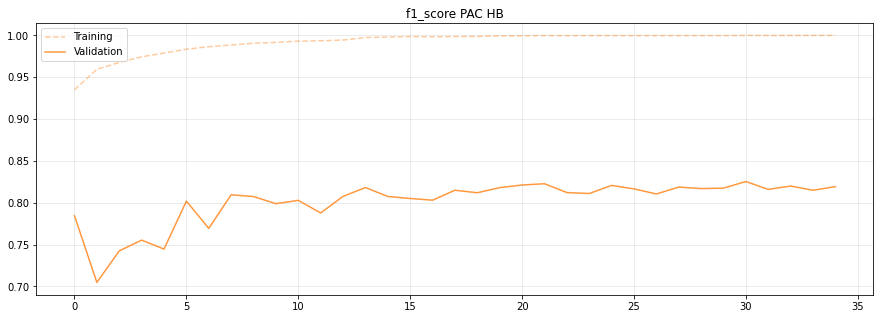

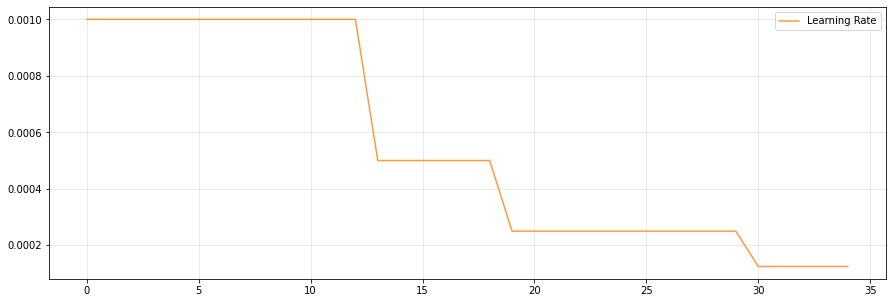

In [ ]:
#plot performances
with open(model_dir + '/history', 'rb') as file:
  history = pickle.load(file)

# Plot and save the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/loss.png')

plt.figure(figsize=(15,5))
plt.plot(history['categorical_accuracy'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical accuracy')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/categorical_accuracy.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_macro'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_macro'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score_macro')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_macro.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_N'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_N'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score Normal HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_N.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_V'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_V'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PVC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_V.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_S'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_S'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PAC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_S.png')

plt.figure(figsize=(15,5))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.legend()
plt.grid(alpha=.3)
plt.savefig(model_dir + '/lr.png')

# Create val and train rows for results df - FOR LAST EPOCH MODEL
results_train_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][-1]))},
                                          index=[0])
results_val_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][-1]))},
                                          index=[0])

results_train_row_tr_vl_ts.to_csv(model_dir + '/results_train_row_tr_vl_ts.csv', index=False)
results_val_row_tr_vl_ts.to_csv(model_dir + '/results_val_row_tr_vl_ts.csv', index=False)

# Create val and train rows for results df - FOR BEST MODEL
if mode == 'max':
  best_epoch = np.where(history[monitoring_metric] == np.amax(history[monitoring_metric]))[0][0]
elif mode == 'min':
  best_epoch = np.where(history[monitoring_metric] == np.amin(history[monitoring_metric]))[0][0]
print('best epoch = ', best_epoch)
results_train_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][best_epoch]))},
                                          index=[0])
results_val_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][best_epoch]))},
                                          index=[0])

results_train_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv', index=False)
results_val_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv', index=False)

print('Train and Val results saved at : ', model_dir)

In [ ]:
results_train_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,0.000182,0.999964,0.99995,0.999989,0.999949,0.999963


In [ ]:
results_train_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,0.000718,0.999785,0.999725,0.999943,0.999665,0.999778


In [ ]:
results_val_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,0.12876,0.986241,0.993224,0.950338,0.819178,0.920913


In [ ]:
results_val_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,0.119631,0.985627,0.992794,0.949989,0.820589,0.921123


#### Evaluate Model

764/764 [==============================] - 10s 12ms/step - loss: 0.1316 - categorical_accuracy: 0.9835 - f1_score_macro: 0.9148 - f1_score_N: 0.9917 - f1_score_V: 0.9554 - f1_score_S: 0.7975
Test loss: 0.131573
Test categorical accuracy:  98.35%
Classes                    N        V        S
Accuracy (%):            [98.489 99.73  98.481]
Specificity (%):         [96.609 99.848 98.687]
Precision (%):           [99.737 95.42  74.44 ]
Sensitivity/Recall (%):  [98.633 96.154 93.438]
F1-score (%):            [0.992 0.958 0.829]
Macro Single F1-score (%):  0.9263333333333333


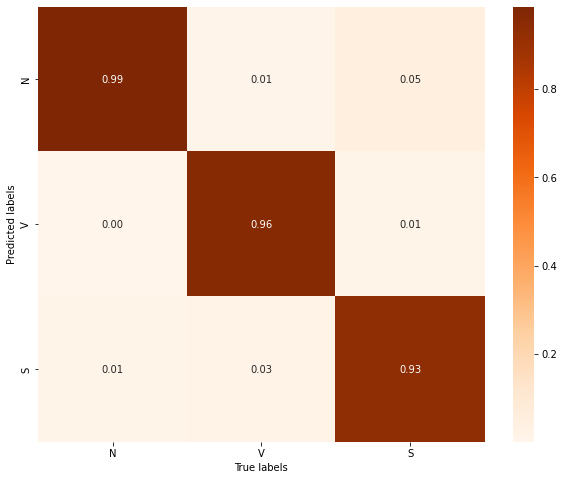

In [ ]:
model = keras.models.load_model(model_dir + '/model', custom_objects={    'f1_score_macro': f1_score_macro,
                                                                          'f1_score_N': f1_score_N,
                                                                          'f1_score_V': f1_score_V,
                                                                          'f1_score_S':f1_score_S} )

score = model.evaluate(X_test, y_test) 
print('Test loss: ' + str(round(score[0],6))) 
print('Test categorical accuracy: ', str(round(score[1]*100,3)) + '%')

# Predict test
pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1) 
true = np.argmax(y_test,axis = 1)

# Plot and save confusion matrix
cm = confusion_matrix(true, pred)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm.T, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Oranges", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig(model_dir + '/test_confusion_matrix.png')

# Commpute and print metrics
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

TPR = TP/(TP+FN) # Sensitivity/Recall
TPR_oa = np.sum(TP) / (np.sum(TP) + np.sum(FN))
TNR = TN/(TN+FP) # Specificity
TNR_oa = np.sum(TN) / (np.sum(TN) + np.sum(FP))
PPV = TP/(TP+FP) # Precision
PPV_oa = np.sum(TP) / (np.sum(TP) + np.sum(FP))

print('Classes                    N        V        S')
print('Accuracy (%):           ', np.around(100*(TP+TN)/(TP+TN+FP+FN),3))
print('Specificity (%):        ', np.around(TNR*100,3))
print('Precision (%):          ', np.around(PPV*100,3))
print('Sensitivity/Recall (%): ', np.around(TPR*100,3))

print('F1-score (%):           ', np.around(2 / (TPR**-1 + PPV**-1), 3))
print('Macro Single F1-score (%): ', np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ))

# To add to resulst DF
results_test_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                        "loss":float("{:.6f}".format(score[0])),
                        "cat_accuracy":float("{:.6f}".format(score[1])),
                        "f1_score_N":float("{:.6f}".format(score[3])), 
                        "f1_score_V":float("{:.6f}".format(score[4])), 
                        "f1_score_S":float("{:.6f}".format(score[5])),
                        "f1_score_macro":float("{:.6f}".format(score[2]))},
                         index=[0])

results_test_row_tr_vl_ts.to_csv(model_dir + '/results_test_row_tr_vl_ts.csv', index=False)

full_test_row = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
full_test_row.loc[0, 'Model Filename'] =  os.path.basename(model_dir)
full_test_row.loc[0, 'Class'] =  ['N', 'V', 'S']
full_test_row.loc[0, 'Accuracy'] =  np.around(100*(TP+TN)/(TP+TN+FP+FN),3).tolist()
full_test_row.loc[0, 'Specificity'] =  np.around(TNR*100,3).tolist()
full_test_row.loc[0, 'Precision'] =  np.around(PPV*100,3).tolist()
full_test_row.loc[0, 'Recall'] = np.around(TPR*100,3).tolist()
full_test_row.loc[0, 'F1-score'] =  np.around(2 / (TPR**-1 + PPV**-1), 3).tolist()
full_test_row.loc[0, 'Macro-F1-score'] =  np.round( np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ), 3)

full_test_row.to_csv(model_dir + '/full_test_row.csv', index=False)

# [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]

# for weighted [np.count_nonzero(true == 0)/len(true), np.count_nonzero(true == 1)/len(true), np.count_nonzero(true == 2)/len(true)]))

In [ ]:
full_test_row

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,"[N, V, S]","[98.489, 99.73, 98.481]","[96.609, 99.848, 98.687]","[99.737, 95.42, 74.44]","[98.633, 96.154, 93.438]","[0.992, 0.958, 0.829]",0.926


In [ ]:
results_test_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07,0.131573,0.983497,0.991684,0.955383,0.797465,0.914844


#### Add results to results DF_train_val_test and DF_full_test

In [ ]:
print('model_saving_dir: ' + model_dir)

new = False
if os.path.exists(rsults_directory + '/results_tr_vl_ts.csv') == False:
  results_tr_vl_ts = pd.DataFrame(columns=['Model Filename',
                                           'subset',
                                          'loss',
                                          'cat_accuracy',
                                          'f1_score_N',
                                          'f1_score_S',
                                          'f1_score_V',
                                          'f1_score_macro'])
  new = True
  results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

# Current model's index on DF's
if new:
  current_index = 0
else:
  current_index = results_tr_vl_ts.index[-1] + 1

# Load previously generated tes, train and val rows
results_test_row_tr_vl_ts  = pd.read_csv(model_dir + '/results_test_row_tr_vl_ts.csv')
results_train_row_tr_vl_ts = pd.read_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv')
results_val_row_tr_vl_ts   = pd.read_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv')

# We could also create easily 3 different DF for the model results on each set

# Fill the jointDF with the data from the columns
for col_str in results_tr_vl_ts.columns:
  if col_str == 'Model Filename':
    results_tr_vl_ts.loc[current_index, col_str] = os.path.basename(model_dir)
  elif col_str == 'subset':
    results_tr_vl_ts.loc[current_index, col_str] = ['train','val','test']
  else:
    train = results_train_row_tr_vl_ts.loc[0, col_str]
    val   = results_val_row_tr_vl_ts.loc[0, col_str]
    test  = results_test_row_tr_vl_ts.loc[0, col_str]

    results_tr_vl_ts.loc[current_index, col_str] = [train, val, test]

# Save updated DF
results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

# Load previously generated full_test_row for current model
full_test_row  = pd.read_csv(model_dir + '/full_test_row.csv')

if os.path.exists(rsults_directory + '/full_test.csv') == False:
  full_test = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
else:
  full_test = pd.read_csv(rsults_directory + '/full_test.csv')

full_test_row = full_test_row.rename(index = {
  0: current_index
})
full_test = pd.concat([full_test, full_test_row], axis=0)

# Save updated DF
full_test.to_csv(rsults_directory + '/full_test.csv', index=False)

model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_resnet_ncw_bs64_smoteY_bpfilt35_Jun16_13-47-07


In [ ]:
full_test

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_Jun01_14-53-57,"['N', 'V', 'S']","[98.071, 99.308, 98.002]","[82.874, 99.475, 99.395]","[98.693, 85.565, 81.217]","[99.237, 94.231, 63.958]","[0.99, 0.897, 0.716]",0.868
1,model_resnet_2epoch_Jun01_17-00-32,"['N', 'V', 'S']","[98.608, 99.627, 98.571]","[87.874, 99.772, 99.467]","[99.073, 93.225, 85.482]","[99.431, 95.256, 76.667]","[0.993, 0.942, 0.808]",0.914
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['N', 'V', 'S']","[98.812, 99.619, 98.792]","[88.851, 99.86, 99.523]","[99.148, 95.618, 87.402]","[99.577, 92.308, 80.938]","[0.994, 0.939, 0.84]",0.924
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
5,model_resnet_bs64_Jun04_14-50-45,"['N', 'V', 'S']","[99.169, 99.767, 99.115]","[93.563, 99.898, 99.565]","[99.507, 96.887, 89.241]","[99.599, 95.769, 88.125]","[0.996, 0.963, 0.887]",0.949
6,model_resnet_cw_bs64_Jun04_16-43-53,"['N', 'V', 'S']","[98.448, 99.726, 98.468]","[96.379, 99.835, 98.687]","[99.719, 95.07, 74.376]","[98.607, 96.41, 93.125]","[0.992, 0.957, 0.827]",0.925
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['N', 'V', 'S']","[98.047, 99.701, 98.092]","[96.897, 99.763, 98.303]","[99.758, 93.162, 69.147]","[98.135, 97.821, 92.917]","[0.989, 0.954, 0.793]",0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['N', 'V', 'S']","[97.514, 99.656, 97.547]","[97.816, 99.738, 97.677]","[99.828, 92.439, 62.44]","[97.491, 97.179, 94.375]","[0.986, 0.947, 0.752]",0.895
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['N', 'V', 'S']","[97.641, 99.627, 97.678]","[97.644, 99.734, 97.813]","[99.815, 92.27, 63.848]","[97.641, 96.41, 94.375]","[0.987, 0.943, 0.762]",0.897


In [ ]:
results_tr_vl_ts

,Model Filename,subset,loss,cat_accuracy,f1_score_N,f1_score_S,f1_score_V,f1_score_macro
0,model_vgg_Jun01_14-53-57,"['train', 'val', 'test']","[0.07002, 0.068835, 0.068096]","[0.976838, 0.976782, 0.976904]","[0.989101, 0.988882, 0.989476]","[0.685058, 0.673492, 0.691116]","[0.870161, 0.875416, 0.885083]","[0.848105, 0.845929, 0.855224]"
1,model_resnet_2epoch_Jun01_17-00-32,"['train', 'val', 'test']","[0.056446, 0.047695, 0.046946]","[0.981952, 0.983457, 0.984029]","[0.991561, 0.992054, 0.9924]","[0.750074, 0.770279, 0.779728]","[0.896693, 0.906843, 0.936126]","[0.879442, 0.889725, 0.90275]"
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['train', 'val', 'test']","[0.048053, 0.045113, 0.043579]","[0.984224, 0.984972, 0.986118]","[0.99253, 0.992821, 0.993525]","[0.786369, 0.787288, 0.810451]","[0.915594, 0.917853, 0.9374]","[0.898162, 0.89932, 0.913791]"
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.012343, 0.082473, 0.035445]","[0.995153, 0.987142, 0.988657]","[0.997623, 0.993635, 0.994702]","[0.931219, 0.813162, 0.841445]","[0.979216, 0.932145, 0.959939]","[0.969352, 0.91298, 0.932028]"
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.032812, 0.03467, 0.035445]","[0.988713, 0.98833, 0.988657]","[0.994646, 0.994398, 0.994702]","[0.839198, 0.835144, 0.841445]","[0.944564, 0.941289, 0.959939]","[0.926136, 0.92361, 0.932028]"
5,model_resnet_bs64_Jun04_14-50-45,"['train', 'val', 'test']","[0.018043, 0.029661, 0.031787]","[0.993115, 0.989845, 0.990254]","[0.996708, 0.995236, 0.995462]","[0.903137, 0.858398, 0.861895]","[0.971582, 0.951401, 0.962117]","[0.957141, 0.935012, 0.939824]"
6,model_resnet_cw_bs64_Jun04_16-43-53,"['train', 'val', 'test']","[0.021232, 0.054751, 0.061469]","[0.990464, 0.985668, 0.983211]","[0.994993, 0.992735, 0.991456]","[0.872368, 0.824751, 0.791478]","[0.977793, 0.955182, 0.954702]","[0.948382, 0.924222, 0.912545]"
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['train', 'val', 'test']","[0.038509, 0.062768, 0.062349]","[0.981194, 0.98014, 0.979197]","[0.98998, 0.989953, 0.989237]","[0.788735, 0.770097, 0.746859]","[0.957377, 0.930297, 0.951051]","[0.912028, 0.896782, 0.895716]"
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['train', 'val', 'test']","[0.055368, 0.066076, 0.073789]","[0.973885, 0.974735, 0.973587]","[0.986069, 0.98698, 0.986254]","[0.732356, 0.727277, 0.705014]","[0.934867, 0.927618, 0.947304]","[0.884429, 0.880625, 0.879524]"
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['train', 'val', 'test']","[0.049204, 0.065158, 0.072744]","[0.977038, 0.976455, 0.974734]","[0.98781, 0.987842, 0.986971]","[0.75938, 0.738188, 0.720136]","[0.933524, 0.922881, 0.940231]","[0.893569, 0.88297, 0.882446]"


In [ ]:
# Computing variance/ measure of overfitting
# new df everytime running all computation again

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

variance_macro_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])
variance_S_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])

test_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
val_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
train_f1_score_macro = np.empty((len(results_tr_vl_ts),1))

test_f1_score_S = np.empty((len(results_tr_vl_ts),1))
val_f1_score_S = np.empty((len(results_tr_vl_ts),1))
train_f1_score_S = np.empty((len(results_tr_vl_ts),1))

for k in range(len(results_tr_vl_ts)):
  test_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])
  
  test_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])

avoidable_bias = 1 - train_f1_score_macro
variance = np.abs(train_f1_score_macro - val_f1_score_macro)
dev_test_variance = np.abs(val_f1_score_macro - test_f1_score_macro)

avoidable_bias_S = 1 - train_f1_score_S
variance_S = np.abs(train_f1_score_S - val_f1_score_S)
dev_test_variance_S = np.abs(val_f1_score_S - test_f1_score_S)

variance_macro_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_macro_df['avoidable_bias'] = avoidable_bias
variance_macro_df['variance'] = variance
variance_macro_df['dev_test_variance'] = dev_test_variance

variance_S_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_S_df['avoidable_bias'] = avoidable_bias_S
variance_S_df['variance'] = variance_S
variance_S_df['dev_test_variance'] = dev_test_variance_S

# Save updated DF
variance_S_df.to_csv(rsults_directory + '/variance_S_df.csv', index=False)
# Save updated DF
variance_macro_df.to_csv(rsults_directory + '/variance_macro_df.csv', index=False)


,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524


### ***3.6*** VGGNet based CNN

https://www.hindawi.com/journals/jhe/2021/7167891/#disclosure

In [ ]:
batchsize = 64
patience_es = 20
patience_rop = 8
epochs = 100
learning_rate = 0.001

model_name = 'model_Zhang2021_elu_ncw_esf1_bs' + str(batchsize) + '_smote' + smote + '_bpfilt35'
print(model_name)

model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35


In [ ]:
def build_Zhang2021(input_shape, learning_rate):
  # Build model
  model = Sequential()

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="relu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="relu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Flatten())

  model.add (Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add (Dense(3,activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

  return model

def build_Zhang2021_elu(input_shape, learning_rate):
  # Build model
  model = Sequential()

  model.add(Conv1D(input_shape=input_shape, filters=16, kernel_size=3, activation="elu"))
  model.add(Conv1D(filters=16,kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=32, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=64, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=64, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(Conv1D(filters=128, kernel_size=3, activation="elu", kernel_initializer = GlorotUniform(SEED)))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Flatten())

  model.add (Dense(30, activation='elu'))
  model.add (Dense(3,activation='softmax'))

  return model

In [ ]:

model = build_Zhang2021_elu(input_shape = X_train.shape[1:], learning_rate=learning_rate)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 198, 16)           112       
                                                                 
 conv1d_21 (Conv1D)          (None, 196, 16)           784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 16)           0         
 1D)                                                             
                                                                 
 conv1d_22 (Conv1D)          (None, 96, 32)            1568      
                                                                 
 conv1d_23 (Conv1D)          (None, 94, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 47, 32)           0         
 1D)                                                    

In [ ]:
# ========= Defining saving directory - model_saving_dir =========
now = datetime.now().strftime('%b%d_%H-%M-%S')

model_dir = os.path.join(exp_directory, model_name + '_' + str(now))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print('Directory created named:   ' + model_dir)

# ========= Compile model =========
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss = 'categorical_crossentropy',
    metrics = [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]
)

# ========= Create folders and callbacks and fit =========
monitoring_metric = 'val_f1_score_macro'
mode = 'max'
callbacks = create_folders_and_callbacks(model_dir, patience_es, patience_rop, monitoring_metric = monitoring_metric, mode_metric = mode)

history = model.fit(
    x = X_train_final,
    y = y_train_final, 
    validation_data=(X_val, y_val),
    batch_size = batchsize,
    epochs = epochs,
    callbacks = callbacks
    # class_weight = class_weights
).history

# Save best epoch model
model.save(model_dir + '/model')

# Save history
with open(model_dir + '/history', 'wb') as file:
    pickle.dump(history, file)

print('History and Model saved at : ', model_dir)
print('Last epoch model saved at : ' + model_dir  + '/lastepoch_model')

Directory created named:   /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49
Epoch 1/100
3053/3053 [==============================] - 28s 8ms/step - loss: 0.0727 - categorical_accuracy: 0.9767 - f1_score_macro: 0.8481 - f1_score_N: 0.9890 - f1_score_V: 0.8642 - f1_score_S: 0.6911 - val_loss: 0.0476 - val_categorical_accuracy: 0.9847 - val_f1_score_macro: 0.9004 - val_f1_score_N: 0.9930 - val_f1_score_V: 0.9106 - val_f1_score_S: 0.7976 - lr: 0.0010
Epoch 2/100
3053/3053 [==============================] - 28s 9ms/step - loss: 0.0507 - categorical_accuracy: 0.9831 - f1_score_macro: 0.8881 - f1_score_N: 0.9921 - f1_score_V: 0.9084 - f1_score_S: 0.7638 - val_loss: 0.0477 - val_categorical_accuracy: 0.9844 - val_f1_score_macro: 0.9025 - val_f1_score_N: 0.9924 - val_f1_score_V: 0.8937 - val_f1_score_S: 0.8212 - lr: 0.0010
Epoch 3/100
3053/3053 [==============================] - 26s 9ms/step - loss: 0.0

#### Plotting Training


In [ ]:
# model_dir = '/content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_cw_lt_esf1_bs64_Jun04_20-14-38'
# monitoring_metric = 'val_f1_score_macro'
# mode = 'max'

best epoch =  34
Train and Val results saved at :  /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49


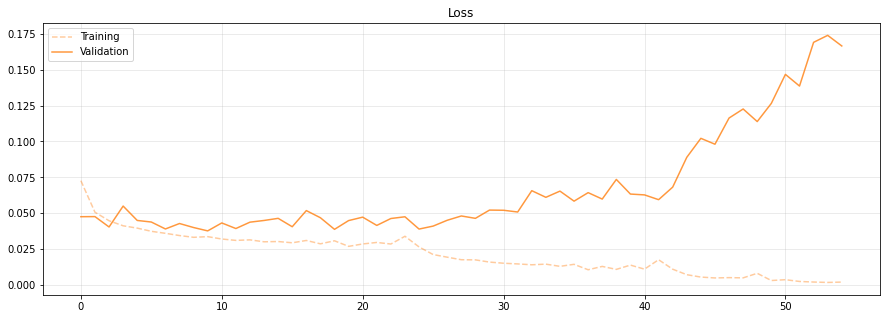

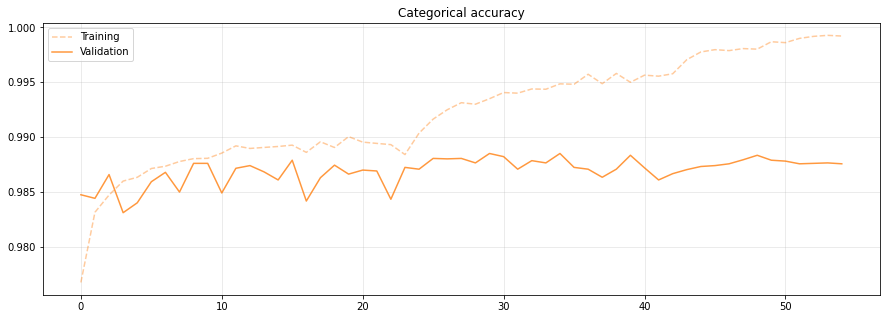

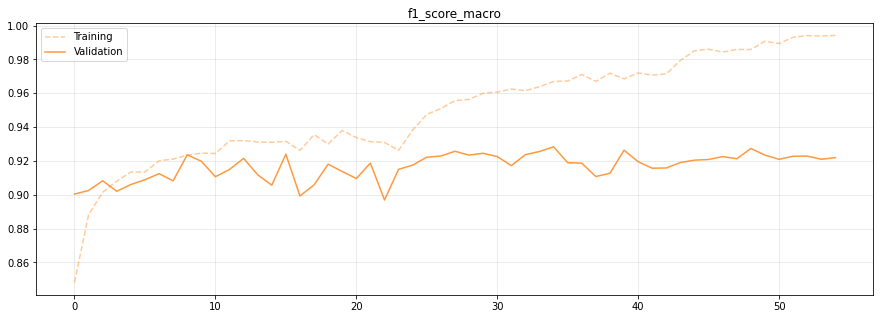

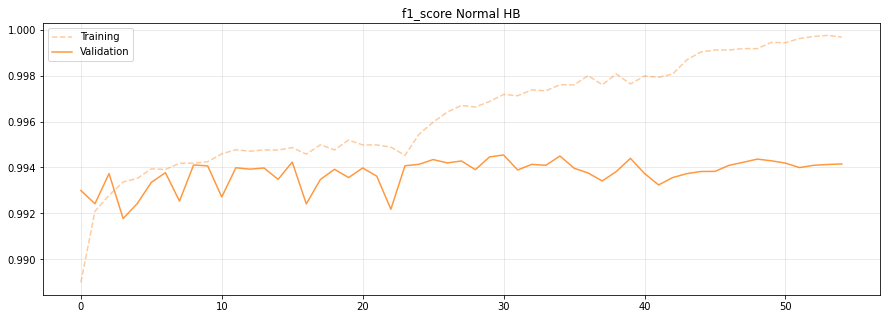

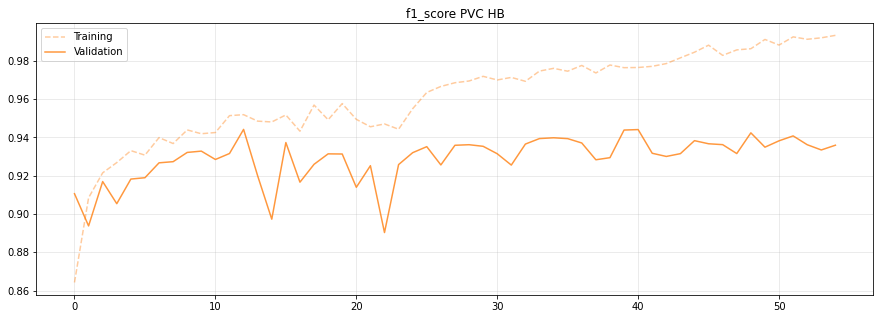

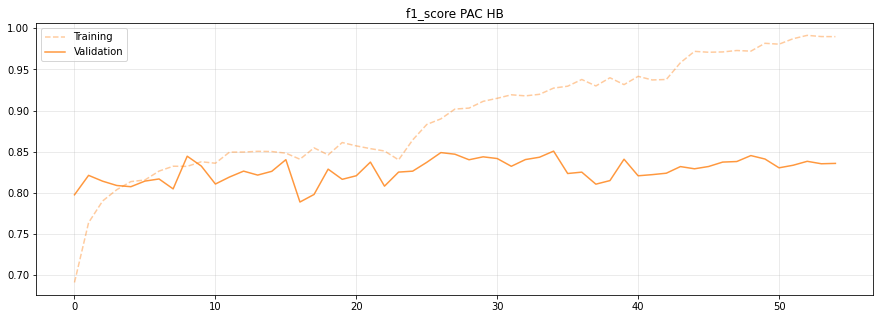

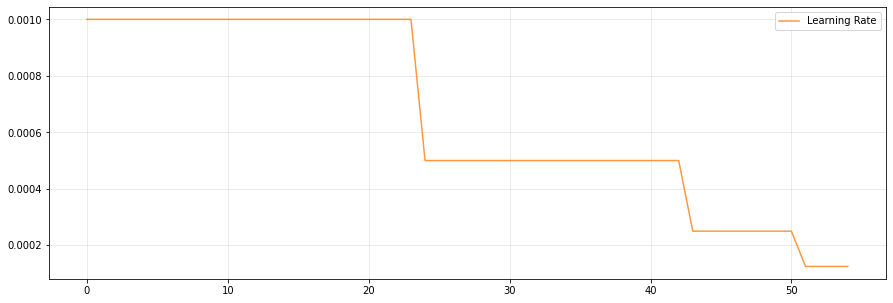

In [ ]:
#plot performances
with open(model_dir + '/history', 'rb') as file:
  history = pickle.load(file)

# Plot and save the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/loss.png')

plt.figure(figsize=(15,5))
plt.plot(history['categorical_accuracy'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical accuracy')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/categorical_accuracy.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_macro'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_macro'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score_macro')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_macro.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_N'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_N'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score Normal HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_N.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_V'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_V'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PVC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_V.png')

plt.figure(figsize=(15,5))
plt.plot(history['f1_score_S'], label='Training', alpha=.4, color='#ff7f0e', linestyle='--')
plt.plot(history['val_f1_score_S'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('f1_score PAC HB')
plt.grid(alpha=.3)
plt.savefig(model_dir + '/f1_score_S.png')

plt.figure(figsize=(15,5))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.legend()
plt.grid(alpha=.3)
plt.savefig(model_dir + '/lr.png')

# Create val and train rows for results df - FOR LAST EPOCH MODEL
results_train_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][-1]))},
                                          index=[0])
results_val_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][-1])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][-1])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][-1])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][-1])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][-1])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][-1]))},
                                          index=[0])

results_train_row_tr_vl_ts.to_csv(model_dir + '/results_train_row_tr_vl_ts.csv', index=False)
results_val_row_tr_vl_ts.to_csv(model_dir + '/results_val_row_tr_vl_ts.csv', index=False)

# Create val and train rows for results df - FOR BEST MODEL
if mode == 'max':
  best_epoch = np.where(history[monitoring_metric] == np.amax(history[monitoring_metric]))[0][0]
elif mode == 'min':
  best_epoch = np.where(history[monitoring_metric] == np.amin(history[monitoring_metric]))[0][0]
print('best epoch = ', best_epoch)
results_train_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['f1_score_macro'][best_epoch]))},
                                          index=[0])
results_val_row_tr_vl_ts_bestepoch = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                                          "loss":float("{:.6f}".format(history['val_loss'][best_epoch])),
                                          "cat_accuracy":float("{:.6f}".format(history['val_categorical_accuracy'][best_epoch])),
                                          "f1_score_N":float("{:.6f}".format(history['val_f1_score_N'][best_epoch])),
                                          "f1_score_V":float("{:.6f}".format(history['val_f1_score_V'][best_epoch])), 
                                          "f1_score_S":float("{:.6f}".format(history['val_f1_score_S'][best_epoch])),
                                          "f1_score_macro":float("{:.6f}".format(history['val_f1_score_macro'][best_epoch]))},
                                          index=[0])

results_train_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv', index=False)
results_val_row_tr_vl_ts_bestepoch.to_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv', index=False)

print('Train and Val results saved at : ', model_dir)

In [ ]:
print(best_epoch, len(history['f1_score_N']))

34 55


In [ ]:
results_train_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,0.002086,0.999217,0.999672,0.993259,0.98983,0.994253


In [ ]:
results_train_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,0.013049,0.994851,0.9976,0.976031,0.927287,0.966972


In [ ]:
results_val_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,0.166446,0.987552,0.994153,0.935886,0.835763,0.921934


In [ ]:
results_val_row_tr_vl_ts_bestepoch

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,0.065411,0.988494,0.994498,0.939762,0.850679,0.928312


#### Evaluate Model

764/764 [==============================] - 4s 5ms/step - loss: 0.0625 - categorical_accuracy: 0.9883 - f1_score_macro: 0.9348 - f1_score_N: 0.9942 - f1_score_V: 0.9633 - f1_score_S: 0.8470
Test loss: 0.062499
Test categorical accuracy:  98.829%
Classes                    N        V        S
Accuracy (%):            [98.939 99.779 98.939]
Specificity (%):         [92.874 99.92  99.39 ]
Precision (%):           [99.453 97.513 85.512]
Sensitivity/Recall (%):  [99.405 95.513 87.917]
F1-score (%):            [0.994 0.965 0.867]
Macro Single F1-score (%):  0.9420000000000001


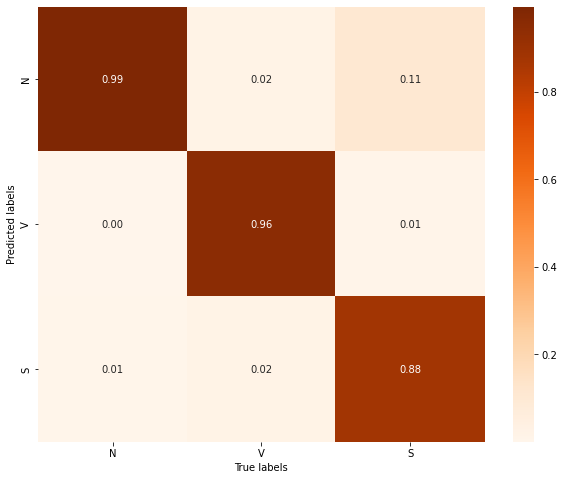

In [ ]:
model = keras.models.load_model(model_dir + '/model', custom_objects={    'f1_score_macro': f1_score_macro,
                                                                          'f1_score_N': f1_score_N,
                                                                          'f1_score_V': f1_score_V,
                                                                          'f1_score_S':f1_score_S} )

score = model.evaluate(X_test, y_test) 
print('Test loss: ' + str(round(score[0],6))) 
print('Test categorical accuracy: ', str(round(score[1]*100,3)) + '%')

# Predict test
pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1) 
true = np.argmax(y_test,axis = 1)

# Plot and save confusion matrix
cm = confusion_matrix(true, pred)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm.T, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Oranges", annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig(model_dir + '/test_confusion_matrix.png')

# Commpute and print metrics
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

TPR = TP/(TP+FN + K.epsilon()) # Sensitivity/Recall
TPR_oa = np.sum(TP) / (np.sum(TP) + np.sum(FN))
TNR = TN/(TN+FP) # Specificity
TNR_oa = np.sum(TN) / (np.sum(TN) + np.sum(FP))
PPV = TP/(TP+FP + K.epsilon()) # Precision
PPV_oa = np.sum(TP) / (np.sum(TP) + np.sum(FP))

print('Classes                    N        V        S')
print('Accuracy (%):           ', np.around(100*(TP+TN)/(TP+TN+FP+FN),3))
print('Specificity (%):        ', np.around(TNR*100,3))
print('Precision (%):          ', np.around(PPV*100,3))
print('Sensitivity/Recall (%): ', np.around(TPR*100,3))

print('F1-score (%):           ', np.around(2 / ((TPR+K.epsilon())**-1 + (PPV+ K.epsilon())**-1), 3))
print('Macro Single F1-score (%): ', np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ))

# To add to resulst DF
results_test_row_tr_vl_ts = pd.DataFrame({'Model Filename': os.path.basename(model_dir), 
                        "loss":float("{:.6f}".format(score[0])),
                        "cat_accuracy":float("{:.6f}".format(score[1])),
                        "f1_score_N":float("{:.6f}".format(score[3])), 
                        "f1_score_V":float("{:.6f}".format(score[4])), 
                        "f1_score_S":float("{:.6f}".format(score[5])),
                        "f1_score_macro":float("{:.6f}".format(score[2]))},
                         index=[0])

results_test_row_tr_vl_ts.to_csv(model_dir + '/results_test_row_tr_vl_ts.csv', index=False)

full_test_row = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
full_test_row.loc[0, 'Model Filename'] =  os.path.basename(model_dir)
full_test_row.loc[0, 'Class'] =  ['N', 'V', 'S']
full_test_row.loc[0, 'Accuracy'] =  np.around(100*(TP+TN)/(TP+TN+FP+FN),3).tolist()
full_test_row.loc[0, 'Specificity'] =  np.around(TNR*100,3).tolist()
full_test_row.loc[0, 'Precision'] =  np.around(PPV*100,3).tolist()
full_test_row.loc[0, 'Recall'] = np.around(TPR*100,3).tolist()
full_test_row.loc[0, 'F1-score'] =  np.around(2 / (TPR**-1 + PPV**-1), 3).tolist()
full_test_row.loc[0, 'Macro-F1-score'] =  np.round( np.mean( np.around(2 / (TPR**-1 + PPV**-1), 3) ), 3)

full_test_row.to_csv(model_dir + '/full_test_row.csv', index=False)

# [metrics.categorical_accuracy, f1_score_macro, f1_score_N, f1_score_V, f1_score_S]

# for weighted [np.count_nonzero(true == 0)/len(true), np.count_nonzero(true == 1)/len(true), np.count_nonzero(true == 2)/len(true)]))

In [ ]:
full_test_row

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,"[N, V, S]","[98.939, 99.779, 98.939]","[92.874, 99.92, 99.39]","[99.453, 97.513, 85.512]","[99.405, 95.513, 87.917]","[0.994, 0.965, 0.867]",0.942


In [ ]:
results_test_row_tr_vl_ts

,Model Filename,loss,cat_accuracy,f1_score_N,f1_score_V,f1_score_S,f1_score_macro
0,model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49,0.062499,0.988288,0.994184,0.963338,0.847002,0.934841


#### Add results to results DF_train_val_test and DF_full_test

In [ ]:
print('model_saving_dir: ' + model_dir)

new = False
if os.path.exists(rsults_directory + '/results_tr_vl_ts.csv') == False:
  results_tr_vl_ts = pd.DataFrame(columns=['Model Filename',
                                           'subset',
                                          'loss',
                                          'cat_accuracy',
                                          'f1_score_N',
                                          'f1_score_S',
                                          'f1_score_V',
                                          'f1_score_macro'])
  new = True
  results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

# Current model's index on DF's
if new:
  current_index = 0
else:
  current_index = results_tr_vl_ts.index[-1] + 1

# Load previously generated tes, train and val rows
results_test_row_tr_vl_ts  = pd.read_csv(model_dir + '/results_test_row_tr_vl_ts.csv')
results_train_row_tr_vl_ts = pd.read_csv(model_dir + '/results_train_row_tr_vl_ts_bestepoch.csv')
results_val_row_tr_vl_ts   = pd.read_csv(model_dir + '/results_val_row_tr_vl_ts_bestepoch.csv')

# We could also create easily 3 different DF for the model results on each set

# Fill the jointDF with the data from the columns
for col_str in results_tr_vl_ts.columns:
  if col_str == 'Model Filename':
    results_tr_vl_ts.loc[current_index, col_str] = os.path.basename(model_dir)
  elif col_str == 'subset':
    results_tr_vl_ts.loc[current_index, col_str] = ['train','val','test']
  else:
    train = results_train_row_tr_vl_ts.loc[0, col_str]
    val   = results_val_row_tr_vl_ts.loc[0, col_str]
    test  = results_test_row_tr_vl_ts.loc[0, col_str]

    results_tr_vl_ts.loc[current_index, col_str] = [train, val, test]

# Save updated DF
results_tr_vl_ts.to_csv(rsults_directory + '/results_tr_vl_ts.csv', index=False)

# Load previously generated full_test_row for current model
full_test_row  = pd.read_csv(model_dir + '/full_test_row.csv')

if os.path.exists(rsults_directory + '/full_test.csv') == False:
  full_test = pd.DataFrame(columns=['Model Filename', 'Class', 'Accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score', 'Macro-F1-score'])
else:
  full_test = pd.read_csv(rsults_directory + '/full_test.csv')

full_test_row = full_test_row.rename(index = {
  0: current_index
})
full_test = pd.concat([full_test, full_test_row], axis=0)

# Save updated DF
full_test.to_csv(rsults_directory + '/full_test.csv', index=False)

model_saving_dir: /content/drive/My Drive/Faculdade/Erasmus 5AS1/AppliedAI/Project/experiments/model_Zhang2021_elu_ncw_esf1_bs64_smoteN_bpfilt35_Jun16_16-04-49


In [ ]:
full_test

,Model Filename,Class,Accuracy,Specificity,Precision,Recall,F1-score,Macro-F1-score
0,model_vgg_Jun01_14-53-57,"['N', 'V', 'S']","[98.071, 99.308, 98.002]","[82.874, 99.475, 99.395]","[98.693, 85.565, 81.217]","[99.237, 94.231, 63.958]","[0.99, 0.897, 0.716]",0.868
1,model_resnet_2epoch_Jun01_17-00-32,"['N', 'V', 'S']","[98.608, 99.627, 98.571]","[87.874, 99.772, 99.467]","[99.073, 93.225, 85.482]","[99.431, 95.256, 76.667]","[0.993, 0.942, 0.808]",0.914
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['N', 'V', 'S']","[98.812, 99.619, 98.792]","[88.851, 99.86, 99.523]","[99.148, 95.618, 87.402]","[99.577, 92.308, 80.938]","[0.994, 0.939, 0.84]",0.924
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['N', 'V', 'S']","[99.029, 99.713, 98.989]","[91.609, 99.822, 99.621]","[99.358, 94.71, 90.011]","[99.599, 96.41, 83.542]","[0.995, 0.956, 0.867]",0.939
5,model_resnet_bs64_Jun04_14-50-45,"['N', 'V', 'S']","[99.169, 99.767, 99.115]","[93.563, 99.898, 99.565]","[99.507, 96.887, 89.241]","[99.599, 95.769, 88.125]","[0.996, 0.963, 0.887]",0.949
6,model_resnet_cw_bs64_Jun04_16-43-53,"['N', 'V', 'S']","[98.448, 99.726, 98.468]","[96.379, 99.835, 98.687]","[99.719, 95.07, 74.376]","[98.607, 96.41, 93.125]","[0.992, 0.957, 0.827]",0.925
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['N', 'V', 'S']","[98.047, 99.701, 98.092]","[96.897, 99.763, 98.303]","[99.758, 93.162, 69.147]","[98.135, 97.821, 92.917]","[0.989, 0.954, 0.793]",0.912
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['N', 'V', 'S']","[97.514, 99.656, 97.547]","[97.816, 99.738, 97.677]","[99.828, 92.439, 62.44]","[97.491, 97.179, 94.375]","[0.986, 0.947, 0.752]",0.895
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['N', 'V', 'S']","[97.641, 99.627, 97.678]","[97.644, 99.734, 97.813]","[99.815, 92.27, 63.848]","[97.641, 96.41, 94.375]","[0.987, 0.943, 0.762]",0.897


In [ ]:

results_tr_vl_ts

,Model Filename,subset,loss,cat_accuracy,f1_score_N,f1_score_S,f1_score_V,f1_score_macro
0,model_vgg_Jun01_14-53-57,"['train', 'val', 'test']","[0.07002, 0.068835, 0.068096]","[0.976838, 0.976782, 0.976904]","[0.989101, 0.988882, 0.989476]","[0.685058, 0.673492, 0.691116]","[0.870161, 0.875416, 0.885083]","[0.848105, 0.845929, 0.855224]"
1,model_resnet_2epoch_Jun01_17-00-32,"['train', 'val', 'test']","[0.056446, 0.047695, 0.046946]","[0.981952, 0.983457, 0.984029]","[0.991561, 0.992054, 0.9924]","[0.750074, 0.770279, 0.779728]","[0.896693, 0.906843, 0.936126]","[0.879442, 0.889725, 0.90275]"
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,"['train', 'val', 'test']","[0.048053, 0.045113, 0.043579]","[0.984224, 0.984972, 0.986118]","[0.99253, 0.992821, 0.993525]","[0.786369, 0.787288, 0.810451]","[0.915594, 0.917853, 0.9374]","[0.898162, 0.89932, 0.913791]"
3,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.012343, 0.082473, 0.035445]","[0.995153, 0.987142, 0.988657]","[0.997623, 0.993635, 0.994702]","[0.931219, 0.813162, 0.841445]","[0.979216, 0.932145, 0.959939]","[0.969352, 0.91298, 0.932028]"
4,model_vgg_ncw_bs64_Jun03_17-14-06,"['train', 'val', 'test']","[0.032812, 0.03467, 0.035445]","[0.988713, 0.98833, 0.988657]","[0.994646, 0.994398, 0.994702]","[0.839198, 0.835144, 0.841445]","[0.944564, 0.941289, 0.959939]","[0.926136, 0.92361, 0.932028]"
5,model_resnet_bs64_Jun04_14-50-45,"['train', 'val', 'test']","[0.018043, 0.029661, 0.031787]","[0.993115, 0.989845, 0.990254]","[0.996708, 0.995236, 0.995462]","[0.903137, 0.858398, 0.861895]","[0.971582, 0.951401, 0.962117]","[0.957141, 0.935012, 0.939824]"
6,model_resnet_cw_bs64_Jun04_16-43-53,"['train', 'val', 'test']","[0.021232, 0.054751, 0.061469]","[0.990464, 0.985668, 0.983211]","[0.994993, 0.992735, 0.991456]","[0.872368, 0.824751, 0.791478]","[0.977793, 0.955182, 0.954702]","[0.948382, 0.924222, 0.912545]"
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,"['train', 'val', 'test']","[0.038509, 0.062768, 0.062349]","[0.981194, 0.98014, 0.979197]","[0.98998, 0.989953, 0.989237]","[0.788735, 0.770097, 0.746859]","[0.957377, 0.930297, 0.951051]","[0.912028, 0.896782, 0.895716]"
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,"['train', 'val', 'test']","[0.055368, 0.066076, 0.073789]","[0.973885, 0.974735, 0.973587]","[0.986069, 0.98698, 0.986254]","[0.732356, 0.727277, 0.705014]","[0.934867, 0.927618, 0.947304]","[0.884429, 0.880625, 0.879524]"
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,"['train', 'val', 'test']","[0.049204, 0.065158, 0.072744]","[0.977038, 0.976455, 0.974734]","[0.98781, 0.987842, 0.986971]","[0.75938, 0.738188, 0.720136]","[0.933524, 0.922881, 0.940231]","[0.893569, 0.88297, 0.882446]"


In [ ]:
# Computing variance/ measure of overfitting
# new df everytime running all computation again

results_tr_vl_ts = pd.read_csv(rsults_directory + '/results_tr_vl_ts.csv')

variance_macro_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])
variance_S_df = pd.DataFrame(columns=['Model Filename',
                                    'avoidable_bias',
                                           'variance',
                                            'dev_test_variance'])

test_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
val_f1_score_macro = np.empty((len(results_tr_vl_ts),1))
train_f1_score_macro = np.empty((len(results_tr_vl_ts),1))

test_f1_score_S = np.empty((len(results_tr_vl_ts),1))
val_f1_score_S = np.empty((len(results_tr_vl_ts),1))
train_f1_score_S = np.empty((len(results_tr_vl_ts),1))

for k in range(len(results_tr_vl_ts)):
  test_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_macro[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])
  
  test_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-9:-1])
  val_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-19:-11])
  if results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21][0] == '[':
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-28:-21])
  else:
    train_f1_score_S[k] = float(results_tr_vl_ts.loc[k,'f1_score_macro'][-29:-21])

avoidable_bias = 1 - train_f1_score_macro
variance = np.abs(train_f1_score_macro - val_f1_score_macro)
dev_test_variance = np.abs(val_f1_score_macro - test_f1_score_macro)

avoidable_bias_S = 1 - train_f1_score_S
variance_S = np.abs(train_f1_score_S - val_f1_score_S)
dev_test_variance_S = np.abs(val_f1_score_S - test_f1_score_S)

variance_macro_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_macro_df['avoidable_bias'] = avoidable_bias
variance_macro_df['variance'] = variance
variance_macro_df['dev_test_variance'] = dev_test_variance

variance_S_df['Model Filename'] = results_tr_vl_ts['Model Filename']
variance_S_df['avoidable_bias'] = avoidable_bias_S
variance_S_df['variance'] = variance_S
variance_S_df['dev_test_variance'] = dev_test_variance_S

# Save updated DF
variance_S_df.to_csv(rsults_directory + '/variance_S_df.csv', index=False)
# Save updated DF
variance_macro_df.to_csv(rsults_directory + '/variance_macro_df.csv', index=False)

In [ ]:
variance_S_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524


In [ ]:
variance_macro_df

,Model Filename,avoidable_bias,variance,dev_test_variance
0,model_vgg_Jun01_14-53-57,0.151895,0.002176,0.009295
1,model_resnet_2epoch_Jun01_17-00-32,0.120560,0.010280,0.013030
2,model_cnn_16326464_3232_2epoch_Jun01_18-07-27,0.101840,0.001160,0.014471
3,model_vgg_ncw_bs64_Jun03_17-14-06,0.030650,0.056370,0.019048
4,model_vgg_ncw_bs64_Jun03_17-14-06,0.073870,0.002520,0.008418
5,model_resnet_bs64_Jun04_14-50-45,0.042859,0.022129,0.004812
6,model_resnet_cw_bs64_Jun04_16-43-53,0.051618,0.024160,0.011677
7,model_Zhang2021_ncw_bs64_Jun04_18-33-51,0.087972,0.015246,0.001066
8,model_Zhang2021_cw_bs64_Jun04_19-11-59,0.115571,0.003804,0.001101
9,model_Zhang2021_cw_lt_bs64_Jun04_19-36-57,0.106440,0.010590,0.000524
